In [1]:
# The fairlearn  original version
from __future__ import annotations

from collections.abc import Callable

# ------------------------
# Imports and constants
# ------------------------
import pandas as pd
import numpy as np
from fairlearn.reductions._moments.moment import ClassificationMoment
from fairlearn.reductions._moments.moment import _GROUP_ID, _LABEL, _PREDICTION, _ALL, _EVENT, _SIGN
from fairlearn.utils._input_validation import _validate_and_reformat_input, _MESSAGE_RATIO_NOT_IN_RANGE
#from fairlearn.reductions._moments.error_rate import ErrorRate

_UPPER_BOUND_DIFF = "upper_bound_diff"
_LOWER_BOUND_DIFF = "lower_bound_diff"
_MESSAGE_INVALID_BOUNDS = "Only one of difference_bound and ratio_bound can be used."
_DEFAULT_DIFFERENCE_BOUND = 0.01

_CTRL_EVENT_FORMAT = "control={0},{1}"

# ------------------------
# Helper functions
# ------------------------
def _combine_event_and_control(event: str, control: str) -> str:
    if pd.notnull(control):
        return _CTRL_EVENT_FORMAT.format(control, event)
    return event


def _merge_event_and_control_columns(event_col: pd.Series, control_col) -> pd.Series:
    if control_col is None:
        return event_col
    return event_col.combine(control_col, _combine_event_and_control)
# ------------------------
# Error Rate class
# ------------------------
_MESSAGE_BAD_COSTS = (
    "costs needs to be a dictionary with keys "
    "'fp' and 'fn' containing non-negative values, which are not both zero"
)

class ErrorRate(ClassificationMoment):
    r"""Misclassification error as a moment with optional costs."""

    def __init__(self, *, costs: dict[Literal["fp", "fn"], float] | None = None):
        """Initialize the ErrorRate with optional false positive/negative costs."""
        super(ErrorRate, self).__init__()
        if costs is None:
            self.fp_cost = 1.0
            self.fn_cost = 1.0
        elif (
            isinstance(costs, dict)
            and costs.keys() == {"fp", "fn"}
            and costs["fp"] >= 0.0
            and costs["fn"] >= 0.0
            and costs["fp"] + costs["fn"] > 0.0
        ):
            self.fp_cost = costs["fp"]
            self.fn_cost = costs["fn"]
        else:
            raise ValueError(_MESSAGE_BAD_COSTS)

    def load_data(self, X, y, *, sensitive_features, control_features=None) -> None:
        _, y_train, sf_train, _ = _validate_and_reformat_input(
            X,
            y,
            enforce_binary_labels=True,
            sensitive_features=sensitive_features,
            control_features=control_features,
        )
        super().load_data(X, y_train, sensitive_features=sf_train)
        self._index = [_ALL]

    @property
    def index(self) -> pd.Index:
        return self._index

    def gamma(self, predictor: Callable) -> pd.Series:
        y_pred = predictor(self.X)
        if isinstance(y_pred, np.ndarray):
            y_pred = np.squeeze(y_pred)
        signed_errors = self.tags[_LABEL] - y_pred
        total_fn_cost = np.sum(signed_errors[signed_errors > 0] * self.fn_cost)
        total_fp_cost = np.sum(-signed_errors[signed_errors < 0] * self.fp_cost)
        error_value = (total_fn_cost + total_fp_cost) / self.total_samples
        error = pd.Series(data=error_value, index=self.index)
        self._gamma_descr = str(error)
        return error

    def project_lambda(self, lambda_vec: pd.Series) -> pd.Series:
        return lambda_vec

    def signed_weights(self, lambda_vec: pd.Series | None = None) -> pd.Series:
        weights = -self.fp_cost + (self.fp_cost + self.fn_cost) * self.tags[_LABEL]
        if lambda_vec is None:
            return weights
        else:
            return lambda_vec[_ALL] * weights
# ------------------------
# UtilityParity
# ------------------------
class UtilityParity(ClassificationMoment):
    def __init__(
        self,
        *,
        difference_bound: float | None = None,
        ratio_bound: float | None = None,
        ratio_bound_slack: float = 0.0,
    ):
        super(UtilityParity, self).__init__()
        if (difference_bound is None) and (ratio_bound is None):
            self.eps = _DEFAULT_DIFFERENCE_BOUND
            self.ratio = 1.0
        elif (difference_bound is not None) and (ratio_bound is None):
            self.eps = difference_bound
            self.ratio = 1.0
        elif (difference_bound is None) and (ratio_bound is not None):
            self.eps = ratio_bound_slack
            if not (0 < ratio_bound <= 1):
                raise ValueError(_MESSAGE_RATIO_NOT_IN_RANGE)
            self.ratio = ratio_bound
        else:
            raise ValueError(_MESSAGE_INVALID_BOUNDS)

    @property
    def index(self) -> pd.MultiIndex:
        return self._index

    def default_objective(self) -> ErrorRate:
        return ErrorRate()

    def load_data(
        self,
        X,
        y: pd.Series,
        *,
        sensitive_features: pd.Series,
        event: pd.Series | None = None,
        utilities=None,
    ) -> None:
        super().load_data(X, y, sensitive_features=sensitive_features)
        self.tags[_EVENT] = event
        if utilities is None:
            utilities = np.vstack([
                np.zeros(y.shape, dtype=np.float64),
                np.ones(y.shape, dtype=np.float64),
            ]).T
        self.utilities = utilities
        self.utility_diff = self.utilities[:, 1] - self.utilities[:, 0]
        self.prob_event = self.tags.groupby(_EVENT).size() / self.total_samples
        self.prob_group_event = self.tags.groupby([_EVENT, _GROUP_ID]).size() / self.total_samples
        signed = pd.concat(
            [self.prob_group_event, self.prob_group_event],
            keys=["+", "-"],
            names=[_SIGN, _EVENT, _GROUP_ID],
        )
        self._index = signed.index
        self.default_objective_lambda_vec = None

        self.U = pd.DataFrame(0, index=self.tags.index, columns=self.index)
        for e, g in self.prob_group_event.index:
            event_select = 1 * (self.tags[_EVENT] == e)
            group_event_select = event_select * (self.tags[_GROUP_ID] == g)
            self.U["+", e, g] = (
                event_select / self.prob_event[e]
                + (-self.ratio) * group_event_select / self.prob_group_event[e, g]
            )
            self.U["-", e, g] = (-self.ratio) * event_select / self.prob_event[
                e
            ] + group_event_select / self.prob_group_event[e, g]

        event_vals = self.tags[_EVENT].dropna().unique()
        group_vals = self.tags[_GROUP_ID].unique()
        self.neg_basis_present = pd.Series(dtype="float64")
        col_count = len(event_vals) * (len(group_vals) - 1)
        self.pos_basis = pd.DataFrame(0.0, index=self.index, columns=range(col_count)).sort_index()
        self.neg_basis = pd.DataFrame(0.0, index=self.index, columns=range(col_count)).sort_index()

        i = 0
        for e in event_vals:
            for g in group_vals[:-1]:
                if ("+", e, g) in self.index:
                    self.pos_basis.loc[("+", e, g), i] = 1
                if ("-", e, g) in self.index:
                    self.neg_basis.loc[("-", e, g), i] = 1
                self.neg_basis_present.at[i] = True
                i += 1

    def gamma(self, predictor: Callable) -> pd.Series:
        predictions = predictor(self.X)
        if isinstance(predictions, np.ndarray):
            predictions = np.squeeze(predictions)
        pred = self.utility_diff.T * predictions + self.utilities[:, 0]
        g_signed = -self.U.T.dot(pred) / self.total_samples
        self._gamma_descr = str(g_signed)
        return g_signed

    def bound(self) -> pd.Series:
        return pd.Series(self.eps, index=self.index)

    def project_lambda(self, lambda_vec: pd.Series) -> pd.Series:
        if self.ratio == 1.0:
            lambda_pos = lambda_vec["+"] - lambda_vec["-"]
            lambda_neg = -lambda_pos
            lambda_pos[lambda_pos < 0.0] = 0.0
            lambda_neg[lambda_neg < 0.0] = 0.0
            lambda_projected = pd.concat(
                [lambda_pos, lambda_neg],
                keys=["+", "-"],
                names=[_SIGN, _EVENT, _GROUP_ID],
            )
            return lambda_projected
        return lambda_vec

    def signed_weights(self, lambda_vec: pd.Series) -> pd.Series:
        return self.utility_diff * self.U.dot(lambda_vec)


UtilityParity.__module__ = "fairlearn.reductions"

# ------------------------
# DemographicParity class
# ------------------------
class DemographicParity(UtilityParity):
    short_name = "DemographicParity"

    def load_data(self, X, y, *, sensitive_features, control_features=None) -> None:
        _, y_train, sf_train, cf_train = _validate_and_reformat_input(
            X,
            y,
            enforce_binary_labels=True,
            sensitive_features=sensitive_features,
            control_features=control_features,
        )
        base_event = pd.Series(data=_ALL, index=y_train.index)
        event = _merge_event_and_control_columns(base_event, cf_train)
        super().load_data(X, y_train, event=event, sensitive_features=sf_train)


# ------------------------
# EqualizedOdds class
# ------------------------
class EqualizedOdds(UtilityParity):
    short_name = "EqualizedOdds"

    def load_data(self, X, y, *, sensitive_features, control_features=None) -> None:
        _, y_train, sf_train, cf_train = _validate_and_reformat_input(
            X,
            y,
            enforce_binary_labels=True,
            sensitive_features=sensitive_features,
            control_features=control_features,
        )
        base_event = y_train.apply(lambda v: _LABEL + "=" + str(v))
        event = _merge_event_and_control_columns(base_event, cf_train)
        super().load_data(X, y_train, event=event, sensitive_features=sf_train)





In [2]:
#The fairlear simple version
# ------------------------
# Imports and constants
# ------------------------
import pandas as pd
import numpy as np
from fairlearn.reductions._moments.moment import ClassificationMoment
from fairlearn.reductions._moments.moment import _GROUP_ID, _LABEL, _PREDICTION, _ALL, _EVENT, _SIGN
from fairlearn.utils._input_validation import _validate_and_reformat_input, _MESSAGE_RATIO_NOT_IN_RANGE


_UPPER_BOUND_DIFF = "upper_bound_diff"
_LOWER_BOUND_DIFF = "lower_bound_diff"
_MESSAGE_INVALID_BOUNDS = "Only one of difference_bound and ratio_bound can be used."
_DEFAULT_DIFFERENCE_BOUND = 0.01
_CTRL_EVENT_FORMAT = "control={0},{1}"

# ------------------------
# Helper functions
# ------------------------
def _combine_event_and_control(event: str, control: str) -> str:
    if pd.notnull(control):
        return _CTRL_EVENT_FORMAT.format(control, event)
    else:
        return event

def _merge_event_and_control_columns(event_col, control_col):
    if control_col is None:
        return event_col
    else:
        return event_col.combine(control_col, _combine_event_and_control)
# ------------------------
# Error Rate class(version simple)
# ------------------------
class ErrorRate1(ClassificationMoment):
    """Misclassification error."""

    short_name = "Err"

    def load_data(self, X, y, *, sensitive_features, control_features=None):
        """Load the specified data into the object."""
        _, y_train, sf_train, cf_train = _validate_and_reformat_input(
            X, y,
            enforce_binary_labels=True,
            sensitive_features=sensitive_features,
            control_features=control_features
        )
        super().load_data(X, y_train, sensitive_features=sf_train)
        self.index = [_ALL]

    def gamma(self, predictor):
        """Return the gamma values for the given predictor."""
        pred = predictor(self.X)
        if isinstance(pred, np.ndarray):
            pred = np.squeeze(pred)  # for safety with TensorFlow
        error = pd.Series(data=(self.tags[_LABEL] - pred).abs().mean(),
                          index=self.index)
        self._gamma_descr = str(error)
        return error

    def project_lambda(self, lambda_vec):
        """Return the lambda values unchanged."""
        return lambda_vec

    def signed_weights(self, lambda_vec=None):
        """Return the signed weights for error rate."""
        base_weights = 2 * self.tags[_LABEL] - 1
        if lambda_vec is None:
            return base_weights
        else:
            return lambda_vec[_ALL] * base_weights


# ------------------------
# UtilityParity1(version simple)
# ------------------------
class UtilityParity1(ClassificationMoment):
    def __init__(self, *, difference_bound=None, ratio_bound=None, ratio_bound_slack=0.0):
        super(UtilityParity1, self).__init__()
        if (difference_bound is None) and (ratio_bound is None):
            self.eps = _DEFAULT_DIFFERENCE_BOUND
            self.ratio = 1.0
        elif (difference_bound is not None) and (ratio_bound is None):
            self.eps = difference_bound
            self.ratio = 1.0
        elif (difference_bound is None) and (ratio_bound is not None):
            self.eps = ratio_bound_slack
            if not (0 < ratio_bound <= 1):
                raise ValueError(_MESSAGE_RATIO_NOT_IN_RANGE)
            self.ratio = ratio_bound
        else:
            raise ValueError(_MESSAGE_INVALID_BOUNDS)

    def default_objective(self):
        return ErrorRate1()

    def load_data(self, X, y: pd.Series, *, sensitive_features: pd.Series, event: pd.Series = None, utilities=None):
        super().load_data(X, y, sensitive_features=sensitive_features)
        self.tags[_EVENT] = event
        if utilities is None:
            utilities = np.vstack([np.zeros(y.shape), np.ones(y.shape)]).T
        self.utilities = utilities
        self.prob_event = self.tags.groupby(_EVENT).size() / self.total_samples
        self.prob_group_event = self.tags.groupby([_EVENT, _GROUP_ID]).size() / self.total_samples
        signed = pd.concat([self.prob_group_event, self.prob_group_event],
                           keys=["+", "-"],
                           names=[_SIGN, _EVENT, _GROUP_ID])
        self.index = signed.index
        self.default_objective_lambda_vec = None

        event_vals = self.tags[_EVENT].dropna().unique()
        group_vals = self.tags[_GROUP_ID].unique()
        self.pos_basis = pd.DataFrame(index=self.index)
        self.neg_basis = pd.DataFrame(index=self.index)
        self.neg_basis_present = pd.Series(dtype='float64')
        zero_vec = pd.Series(0.0, self.index)
        i = 0
        for event_val in event_vals:
            for group in group_vals[:-1]:
                self.pos_basis[i] = 0 + zero_vec
                self.neg_basis[i] = 0 + zero_vec
                self.pos_basis.loc[("+", event_val, group), i] = 1
                self.neg_basis.loc[("-", event_val, group), i] = 1
                self.neg_basis_present.at[i] = True
                i += 1

    def gamma(self, predictor):
        utility_diff = self.utilities[:, 1] - self.utilities[:, 0]
        predictions = predictor(self.X)
        predictions = np.squeeze(predictions)
        pred = utility_diff.T * predictions + self.utilities[:, 0]
        self.tags[_PREDICTION] = pred
        expect_event = self.tags.groupby(_EVENT)[[_PREDICTION]].mean()
        expect_group_event = self.tags.groupby([_EVENT, _GROUP_ID])[_PREDICTION].mean().to_frame()
        expect_group_event[_UPPER_BOUND_DIFF] = self.ratio * expect_group_event[_PREDICTION] - expect_event[_PREDICTION].reindex(expect_group_event.index.get_level_values(0)).values
        expect_group_event[_LOWER_BOUND_DIFF] = - expect_group_event[_PREDICTION] + self.ratio * expect_event[_PREDICTION].reindex(expect_group_event.index.get_level_values(0)).values
        g_signed = pd.concat([expect_group_event[_UPPER_BOUND_DIFF],
                              expect_group_event[_LOWER_BOUND_DIFF]],
                             keys=["+", "-"],
                             names=[_SIGN, _EVENT, _GROUP_ID])
        self._gamma_descr = str(expect_group_event[[_PREDICTION, _UPPER_BOUND_DIFF, _LOWER_BOUND_DIFF]])
        return g_signed

    def bound(self):
        return pd.Series(self.eps, index=self.index)

    def project_lambda(self, lambda_vec):
        if self.ratio == 1.0:
            lambda_pos = lambda_vec["+"] - lambda_vec["-"]
            lambda_neg = -lambda_pos
            lambda_pos[lambda_pos < 0.0] = 0.0
            lambda_neg[lambda_neg < 0.0] = 0.0
            return pd.concat([lambda_pos, lambda_neg], keys=["+", "-"], names=[_SIGN, _EVENT, _GROUP_ID])
        return lambda_vec

    def signed_weights(self, lambda_vec):
        lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).groupby(level=_EVENT).sum() / self.prob_event
        lambda_group_event = (self.ratio * lambda_vec["+"] - lambda_vec["-"]) / self.prob_group_event
        adjust = lambda_event.reindex(lambda_group_event.index.get_level_values(0)).values - lambda_group_event.values
        adjust_series = pd.Series(adjust, index=lambda_group_event.index)
        signed_weights = self.tags.apply(
            lambda row: 0 if pd.isna(row[_EVENT]) else adjust_series[row[_EVENT], row[_GROUP_ID]], axis=1
        )
        utility_diff = self.utilities[:, 1] - self.utilities[:, 0]
        return utility_diff.T * signed_weights

# ------------------------
# DemographicParity1 class
# ------------------------
class DemographicParity1(UtilityParity1):
    short_name = "DemographicParity1"
    def load_data(self, X, y, *, sensitive_features, control_features=None):
        _, y_train, sf_train, cf_train = _validate_and_reformat_input(
            X, y, enforce_binary_labels=True, sensitive_features=sensitive_features, control_features=control_features)
        base_event = pd.Series(data=_ALL, index=y_train.index)
        event = _merge_event_and_control_columns(base_event, cf_train)
        super().load_data(X, y_train, event=event, sensitive_features=sf_train)

# ------------------------
# EqualizedOdds1 class
# ------------------------
class EqualizedOdds1(UtilityParity1):
    short_name = "EqualizedOdds1"

    def load_data(self, X, y, *, sensitive_features, control_features=None) -> None:
        _, y_train, sf_train, cf_train = _validate_and_reformat_input(
            X,
            y,
            enforce_binary_labels=True,
            sensitive_features=sensitive_features,
            control_features=control_features,
        )
        base_event = y_train.apply(lambda v: _LABEL + "=" + str(v))
        event = _merge_event_and_control_columns(base_event, cf_train)
        super().load_data(X, y_train, event=event, sensitive_features=sf_train)





In [3]:
# Copyright (c) Microsoft Corporation and Fairlearn contributors.
# Licensed under the MIT License.

# =====================
# CONSTANTS DEFINITIONS
# =====================
_PRECISION = 1e-8
_LINE = "_" * 9
_INDENTATION = " " * 9

# Multiplier used to compute nu (threshold on duality gap)
_ACCURACY_MUL = 0.5

# Parameters for learning rate shrinking
_REGRET_CHECK_START_T = 5
_REGRET_CHECK_INCREASE_T = 1.6
_SHRINK_REGRET = 0.8
_SHRINK_ETA = 0.8

# Minimum number of iterations before termination is considered
_MIN_ITER = 5

# =====================================
# LAGRANGIAN CLASS AND HELPER CLASSES
# =====================================

import logging
from collections.abc import Callable
from time import time
import numpy as np
import pandas as pd
import scipy.optimize as opt
from sklearn import clone
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, MetaEstimatorMixin
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_is_fitted

from fairlearn.reductions._moments import ClassificationMoment
from fairlearn.reductions._moments.moment import Moment

logger = logging.getLogger(__name__)

_MESSAGE_BAD_OBJECTIVE = (
    "Objective needs to be of the same type as constraints. Objective is {}, constraints are {}."
)

class _PredictorAsCallable:
    def __init__(self, classifier):
        self._classifier = classifier

    def __call__(self, X):
        return self._classifier.predict(X)

class _GapResult:
    def __init__(self, L, L_low, L_high, gamma, error):
        self.L = L
        self.L_low = L_low
        self.L_high = L_high
        self.gamma = gamma
        self.error = error

    def gap(self):
        return max(self.L - self.L_low, self.L_high - self.L)

class _Lagrangian:
    def __init__(self, *, X, y, estimator, constraints: Moment, B: float, objective: Moment | None = None, opt_lambda: bool = True, sample_weight_name: str = "sample_weight", **kwargs):
        self.constraints = constraints
        self.constraints.load_data(X, y, **kwargs)
        if objective is None:
            self.obj = self.constraints.default_objective()
        elif objective._moment_type() == constraints._moment_type():
            self.obj = objective
        else:
            raise ValueError(_MESSAGE_BAD_OBJECTIVE.format(objective._moment_type(), constraints._moment_type()))
        self.obj.load_data(X, y, **kwargs)
        self.estimator = estimator
        self.B = B
        self.opt_lambda = opt_lambda

        self.hs = pd.Series(dtype="object")
        self.predictors = pd.Series(dtype="object")
        self.errors = pd.Series(dtype="float64")
        self.gammas = pd.DataFrame()
        self.lambdas = pd.DataFrame()
        self.n_oracle_calls = 0
        self.oracle_execution_times = []
        self.n_oracle_calls_dummy_returned = 0
        self.last_linprog_n_hs = 0
        self.last_linprog_result = None
        self.sample_weight_name = sample_weight_name

    def _eval(self, Q, lambda_vec):
        if callable(Q):
            error = self.obj.gamma(Q).iloc[0]
            gamma = self.constraints.gamma(Q)
        else:
            error = self.errors[Q.index].dot(Q)
            gamma = self.gammas[Q.index].dot(Q)
        if self.opt_lambda:
            lambda_vec = self.constraints.project_lambda(lambda_vec)
        L = error + np.sum(lambda_vec * (gamma - self.constraints.bound()))
        max_constraint = (gamma - self.constraints.bound()).max()
        L_high = error
        if max_constraint > 0:
            L_high += self.B * max_constraint
        return L, L_high, gamma, error

    def eval_gap(self, Q, lambda_hat, nu):
        L, L_high, gamma, error = self._eval(Q, lambda_hat)
        result = _GapResult(L, L, L_high, gamma, error)
        for mul in [1.0, 2.0, 5.0, 10.0]:
            _, h_hat_idx = self.best_h(mul * lambda_hat)
            logger.debug("%smul=%.0f", _INDENTATION, mul)
            L_low_mul, _, _, _ = self._eval(pd.Series({h_hat_idx: 1.0}), lambda_hat)
            if L_low_mul < result.L_low:
                result.L_low = L_low_mul
            if result.gap() > nu + _PRECISION:
                break
        return result

    def solve_linprog(self, nu):
        n_hs = len(self.hs)
        n_constraints = len(self.constraints.index)
        if self.last_linprog_n_hs == n_hs:
            return self.last_linprog_result
        c = np.concatenate((self.errors, [self.B]))
        A_ub = np.concatenate((self.gammas.sub(self.constraints.bound(), axis=0), -np.ones((n_constraints, 1))), axis=1)
        b_ub = np.zeros(n_constraints)
        A_eq = np.concatenate((np.ones((1, n_hs)), np.zeros((1, 1))), axis=1)
        b_eq = np.ones(1)
        result = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, method="highs-ds")
        Q = pd.Series(result.x[:-1], self.hs.index)
        dual_c = np.concatenate((b_ub, -b_eq))
        dual_A_ub = np.concatenate((-A_ub.transpose(), A_eq.transpose()), axis=1)
        dual_b_ub = c
        dual_bounds = [(None, None) if i == n_constraints else (0, None) for i in range(n_constraints + 1)]
        result_dual = opt.linprog(dual_c, A_ub=dual_A_ub, b_ub=dual_b_ub, bounds=dual_bounds, method="highs-ds")
        lambda_vec = pd.Series(result_dual.x[:-1], self.constraints.index)
        self.last_linprog_n_hs = n_hs
        self.last_linprog_result = (Q, lambda_vec, self.eval_gap(Q, lambda_vec, nu))
        return self.last_linprog_result
    def _call_oracle(self, lambda_vec):
        signed_weights = self.obj.signed_weights() + self.constraints.signed_weights(lambda_vec)
        if isinstance(self.constraints, ClassificationMoment):
            redY = 1 * (signed_weights > 0)
        else:
            redY = self.constraints._y_as_series
        redW = signed_weights.abs()
        redW = self.constraints.total_samples * redW / redW.sum()
        redY_unique = np.unique(redY)
        if len(redY_unique) == 1:
            logger.debug("redY had single value. Using DummyClassifier")
            estimator = DummyClassifier(strategy="constant", constant=redY_unique[0])
            self.n_oracle_calls_dummy_returned += 1
        else:
            estimator = clone(estimator=self.estimator, safe=False)
        oracle_call_start_time = time()
        estimator.fit(self.constraints.X, redY, **{self.sample_weight_name: redW})
        self.oracle_execution_times.append(time() - oracle_call_start_time)
        self.n_oracle_calls += 1
        return estimator

    def best_h(self, lambda_vec):
        classifier = self._call_oracle(lambda_vec)
        h = _PredictorAsCallable(classifier)
        h_error = self.obj.gamma(h).iloc[0]
        h_gamma = self.constraints.gamma(h)
        h_value = h_error + h_gamma.dot(lambda_vec)
        if not self.hs.empty:
            values = self.errors + self.gammas.transpose().dot(lambda_vec)
            best_idx = values.idxmin()
            best_value = values[best_idx]
        else:
            best_idx = -1
            best_value = np.inf
        if h_value < best_value - _PRECISION:
            logger.debug("%sbest_h: val improvement %f", _LINE, best_value - h_value)
            h_idx = len(self.hs)
            self.hs.at[h_idx] = h
            self.predictors.at[h_idx] = classifier
            self.errors.at[h_idx] = h_error
            self.gammas[h_idx] = h_gamma
            self.lambdas[h_idx] = lambda_vec.copy()
            best_idx = h_idx
        return self.hs[best_idx], best_idx

# =====================================
# EXPONENTIATED GRADIENT CLASS (full)
# =====================================

class ExponentiatedGradient(BaseEstimator, MetaEstimatorMixin):
    def __init__(
        self,
        estimator,
        constraints: Moment,
        *,
        objective: Moment | None = None,
        eps: float = 0.01,
        max_iter: int = 50,
        nu: float | None = None,
        eta0: float = 2.0,
        run_linprog_step: bool = True,
        sample_weight_name: str = "sample_weight",
    ):
        self.estimator = estimator
        self.constraints = constraints
        self.objective = objective
        self.eps = eps
        self.max_iter = max_iter
        self.nu = nu
        self.eta0 = eta0
        self.run_linprog_step = run_linprog_step
        self.sample_weight_name = sample_weight_name

    def fit(self, X, y, **kwargs):
        self.lambda_vecs_EG_ = pd.DataFrame()
        self.lambda_vecs_LP_ = pd.DataFrame()

        logger.debug("...Exponentiated Gradient STARTING")

        B = 1 / self.eps
        lagrangian = _Lagrangian(
            X=X,
            y=y,
            estimator=self.estimator,
            constraints=self.constraints,
            B=B,
            objective=self.objective,
            sample_weight_name=self.sample_weight_name,
            **kwargs,
        )

        theta = pd.Series(0, lagrangian.constraints.index)
        Qsum = pd.Series(dtype="float64")
        gaps_EG = []
        gaps = []
        Qs = []

        last_regret_checked = _REGRET_CHECK_START_T
        last_gap = np.inf

        for t in range(self.max_iter):
            logger.debug("...iter=%03d", t)

            lambda_vec = B * np.exp(theta) / (1 + np.exp(theta).sum())
            self.lambda_vecs_EG_[t] = lambda_vec
            lambda_EG = self.lambda_vecs_EG_.mean(axis=1)

            h, h_idx = lagrangian.best_h(lambda_vec)

            if t == 0:
                if self.nu is None:
                    self.nu = (
                        _ACCURACY_MUL
                        * (h(X) - self.constraints._y_as_series).abs().std()
                        / np.sqrt(self.constraints.total_samples)
                    )
                eta = self.eta0 / B
                logger.debug("...eps=%.3f, B=%.1f, nu=%.6f, max_iter=%d", self.eps, B, self.nu, self.max_iter)

            if h_idx not in Qsum.index:
                Qsum.at[h_idx] = 0.0
            Qsum[h_idx] += 1.0
            gamma = lagrangian.gammas[h_idx]
            Q_EG = Qsum / Qsum.sum()
            result_EG = lagrangian.eval_gap(Q_EG, lambda_EG, self.nu)
            gap_EG = result_EG.gap()
            gaps_EG.append(gap_EG)

            if t == 0 or not self.run_linprog_step:
                gap_LP = np.inf
            else:
                Q_LP, self.lambda_vecs_LP_[t], result_LP = lagrangian.solve_linprog(self.nu)
                gap_LP = result_LP.gap()

            if gap_EG < gap_LP:
                Qs.append(Q_EG)
                gaps.append(gap_EG)
            else:
                Qs.append(Q_LP)
                gaps.append(gap_LP)

            logger.debug("%seta=%.6f, gap=%.6f, gap_LP=%.6f", _INDENTATION, eta, gap_EG, gap_LP)

            if (gaps[t] < self.nu) and (t >= _MIN_ITER):
                break

            if t >= last_regret_checked * _REGRET_CHECK_INCREASE_T:
                best_gap = min(gaps_EG)
                if best_gap > last_gap * _SHRINK_REGRET:
                    eta *= _SHRINK_ETA
                last_regret_checked = t
                last_gap = best_gap

            theta += eta * (gamma - self.constraints.bound())

        gaps_series = pd.Series(gaps)
        gaps_best = gaps_series[gaps_series <= gaps_series.min() + _PRECISION]
        self.best_iter_ = gaps_best.index[-1]
        self.best_gap_ = gaps[self.best_iter_]
        self.weights_ = Qs[self.best_iter_]
        self._hs = lagrangian.hs
        for h_idx in self._hs.index:
            if h_idx not in self.weights_.index:
                self.weights_.at[h_idx] = 0.0

        self.last_iter_ = len(Qs) - 1
        self.predictors_ = lagrangian.predictors
        self.n_oracle_calls_ = lagrangian.n_oracle_calls
        self.n_oracle_calls_dummy_returned_ = lagrangian.n_oracle_calls_dummy_returned
        self.oracle_execution_times_ = lagrangian.oracle_execution_times
        self.lambda_vecs_ = lagrangian.lambdas

        return self

    def predict(self, X, random_state=None):
        check_is_fitted(self)
        random_state = check_random_state(random_state)

        if isinstance(self.constraints, ClassificationMoment):
            positive_probs = self._pmf_predict(X)[:, 1]
            return (positive_probs >= random_state.rand(len(positive_probs))) * 1
        else:
            pred = self._pmf_predict(X)
            randomized_pred = np.zeros(pred.shape[0])
            for i in range(pred.shape[0]):
                randomized_pred[i] = random_state.choice(pred.iloc[i, :], p=self.weights_)
            return randomized_pred

    def _pmf_predict(self, X):
        check_is_fitted(self)

        pred = pd.DataFrame()
        for t in range(len(self._hs)):
            if self.weights_[t] == 0:
                pred[t] = np.zeros(len(X))
            else:
                pred[t] = self._hs[t](X)

        if isinstance(self.constraints, ClassificationMoment):
            positive_probs = pred[self.weights_.index].dot(self.weights_).to_frame()
            return np.concatenate((1 - positive_probs, positive_probs), axis=1)
        else:
            return pred


In [ ]:
# ===============================
#  IMPORT NECESSARY LIBRARIES
# ===============================
import os
import shutil

# ===============================
#  DEFINE PATHS
# ===============================
# Google Drive source files
source_adult = "/content/drive/MyDrive/Fairlearn_project/fairlearn/data/adult.csv"         # Binary classification
source_cmc = "/content/drive/MyDrive/Fairlearn_project/fairlearn/data/cmc_proc.csv"        # Multi-class classification

# Destination folder in Colab project
destination_folder = "/content/fairlearn_project/data"

# ===============================
# CREATE DESTINATION FOLDER IF NEEDED
# ===============================
os.makedirs(destination_folder, exist_ok=True)

# ===============================
#  COPY FILES TO PROJECT FOLDER
# ===============================
shutil.copy(source_adult, destination_folder)
shutil.copy(source_cmc, destination_folder)

# ===============================
#  CONFIRMATION
# ===============================
print(" Data files successfully copied to:", destination_folder)
print(" Files now inside Data folder:", os.listdir(destination_folder))


 Data files successfully copied to: /content/fairlearn_project/data
 Files now inside Data folder: ['adult.csv', 'crime_proc.csv', 'cmc_proc.csv']


In [ ]:
from fairlearn.reductions import ClassificationMoment
from fairlearn.reductions._moments.moment import _ALL, _EVENT, _GROUP_ID, _LABEL, _SIGN
from fairlearn.utils._input_validation import _validate_and_reformat_input
import pandas as pd
import numpy as np
from typing import Callable


class CombinedParity(ClassificationMoment):
    short_name = "CombinedParity"

    def __init__(
        self,
        *,
        use_dp=True,
        use_eo=True,
        dp_bound: float | None = None,
        eo_bound: float | None = None,
        dp_ratio_bound: float | None = None,
        eo_ratio_bound: float | None = None,
        ratio_bound_slack: float = 0.0,
    ):
        if not use_dp and not use_eo:
            raise ValueError("At least one of use_dp or use_eo must be True")

        if dp_bound is not None and dp_ratio_bound is not None:
            raise ValueError("Cannot set both dp_bound and dp_ratio_bound")
        if dp_ratio_bound is not None and not (0 < dp_ratio_bound <= 1):
            raise ValueError("Ratio bound must be in (0, 1]")

        if eo_bound is not None and eo_ratio_bound is not None:
            raise ValueError("Cannot set both eo_bound and eo_ratio_bound")
        if eo_ratio_bound is not None and not (0 < eo_ratio_bound <= 1):
            raise ValueError("Ratio bound must be in (0, 1]")



        self.use_dp = use_dp
        self.use_eo = use_eo
        self.dp_bound = dp_bound
        self.eo_bound = eo_bound
        self.dp_ratio_bound = dp_ratio_bound
        self.eo_ratio_bound = eo_ratio_bound
        self.ratio_bound_slack = ratio_bound_slack

    def load_data(
        self,
        X,
        y: pd.Series,
        *,
        sensitive_features: pd.Series,
        event: pd.Series | None = None,
        utilities=None,
    ) -> None:
        _, y_train, sf_train, _ = _validate_and_reformat_input(
            X,
            y,
            enforce_binary_labels=True,
            sensitive_features=sensitive_features,
        )
        self.tags = pd.DataFrame({_LABEL: y_train, _GROUP_ID: sf_train})
        self._total_samples = len(self.tags)
        self._y = y_train
        self.X = X

        # Create separate event columns for DP and EO
        if event is None:
            if self.use_dp:
                self.tags["dp_event"] = "all"
            if self.use_eo:
                self.tags["eo_event"] = y_train.apply(lambda v: f"label={v}")

            # Create combined event column
            if self.use_dp and self.use_eo:
                self.tags[_EVENT] = "combined_" + y_train.astype(str)
            elif self.use_dp:
                self.tags[_EVENT] = self.tags["dp_event"]
            elif self.use_eo:
                self.tags[_EVENT] = self.tags["eo_event"]

        # Process events and bounds
        events = []
        bounds = []

        if self.use_dp:
            events.append("all")
            bound = self.dp_bound if self.dp_bound is not None else self.ratio_bound_slack
            bounds.append(bound)

        if self.use_eo:
            for label in np.unique(y_train):
                events.append(f"label={label}")
                bound = self.eo_bound if self.eo_bound is not None else self.ratio_bound_slack
                bounds.append(bound)

        # Create index and bounds
        index = []
        bound_vals = []

        for sign in ["+", "-"]:
            for event_name, bound in zip(events, bounds):
                for group in self.tags[_GROUP_ID].unique():
                    index.append((sign, event_name, group))
                    bound_vals.append(bound)

        self._index = pd.MultiIndex.from_tuples(index, names=[_SIGN, _EVENT, _GROUP_ID])
        self.bound_ = pd.Series(bound_vals, index=self._index)

        # Handle utilities
        if utilities is None:
            utilities = np.vstack([
                np.zeros(y.shape, dtype=np.float64),
                np.ones(y.shape, dtype=np.float64),
            ]).T
        self.utilities = utilities
        self.utility_diff = self.utilities[:, 1] - self.utilities[:, 0]

        # Calculate probabilities separately for DP and EO
        if self.use_dp:
            dp_event_col = "dp_event" if self.use_eo else _EVENT
            self.prob_dp_event = self.tags.groupby(dp_event_col).size() / self._total_samples
            self.prob_group_dp_event = self.tags.groupby([dp_event_col, _GROUP_ID]).size() / self._total_samples

        if self.use_eo:
            eo_event_col = "eo_event" if self.use_dp else _EVENT
            self.prob_eo_event = self.tags.groupby(eo_event_col).size() / self._total_samples
            self.prob_group_eo_event = self.tags.groupby([eo_event_col, _GROUP_ID]).size() / self._total_samples

        # Initialize U matrix
        self.U = pd.DataFrame(0, index=self.tags.index, columns=self._index)

        # Process DP constraints
        if self.use_dp:
            e = "all"
            for g in self.tags[_GROUP_ID].unique():
                event_select = 1 * (self.tags["dp_event"] == e) if self.use_eo else 1 * (self.tags[_EVENT] == e)
                group_event_select = event_select * (self.tags[_GROUP_ID] == g)
                ratio = self.dp_ratio_bound if self.dp_ratio_bound is not None else 1.0

                self.U["+", e, g] = (
                    event_select / self.prob_dp_event[e]
                    + (-ratio) * group_event_select / self.prob_group_dp_event[e, g]
                )
                self.U["-", e, g] = (
                    (-ratio) * event_select / self.prob_dp_event[e]
                    + group_event_select / self.prob_group_dp_event[e, g]
                )

        # Process EO constraints
        if self.use_eo:
            for label in np.unique(y_train):
                e = f"label={label}"
                for g in self.tags[_GROUP_ID].unique():
                    event_select = 1 * (self.tags["eo_event"] == e) if self.use_dp else 1 * (self.tags[_EVENT] == e)
                    group_event_select = event_select * (self.tags[_GROUP_ID] == g)
                    ratio = self.eo_ratio_bound if self.eo_ratio_bound is not None else 1.0

                    self.U["+", e, g] = (
                        event_select / self.prob_eo_event[e]
                        + (-ratio) * group_event_select / self.prob_group_eo_event[e, g]
                    )
                    self.U["-", e, g] = (
                        (-ratio) * event_select / self.prob_eo_event[e]
                        + group_event_select / self.prob_group_eo_event[e, g]
                    )

        # Initialize basis matrices
        event_vals = events  # Use the events we defined earlier
        group_vals = self.tags[_GROUP_ID].unique()
        self.neg_basis_present = pd.Series(dtype="float64")
        col_count = len(event_vals) * (len(group_vals) - 1)
        self.pos_basis = pd.DataFrame(0.0, index=self._index, columns=range(col_count)).sort_index()
        self.neg_basis = pd.DataFrame(0.0, index=self._index, columns=range(col_count)).sort_index()

        i = 0
        for e in event_vals:
            for g in group_vals[:-1]:
                if ("+", e, g) in self._index:
                    self.pos_basis.loc[("+", e, g), i] = 1
                if ("-", e, g) in self._index:
                    self.neg_basis.loc[("-", e, g), i] = 1
                self.neg_basis_present.at[i] = True
                i += 1

    @property
    def index(self) -> pd.MultiIndex:
        return self._index

    def bound(self) -> pd.Series:
        return self.bound_

    def default_objective(self) -> ErrorRate:
        return ErrorRate()

    def gamma(self, predictor: Callable) -> pd.Series:
        predictions = predictor(self.X)
        if isinstance(predictions, np.ndarray):
            predictions = np.squeeze(predictions)
        pred = self.utility_diff.T * predictions + self.utilities[:, 0]
        g_signed = -self.U.T.dot(pred) / self._total_samples
        self._gamma_descr = str(g_signed)
        return g_signed

    def project_lambda(self, lambda_vec: pd.Series) -> pd.Series:
        if (self.dp_ratio_bound is None or self.dp_ratio_bound == 1.0) and \
           (self.eo_ratio_bound is None or self.eo_ratio_bound == 1.0):
            lambda_pos = lambda_vec["+"] - lambda_vec["-"]
            lambda_neg = -lambda_pos
            lambda_pos[lambda_pos < 0.0] = 0.0
            lambda_neg[lambda_neg < 0.0] = 0.0
            lambda_projected = pd.concat(
                [lambda_pos, lambda_neg],
                keys=["+", "-"],
                names=[_SIGN, _EVENT, _GROUP_ID],
            )
            return lambda_projected
        return lambda_vec

    def signed_weights(self, lambda_vec: pd.Series) -> pd.Series:
        return self.utility_diff * self.U.dot(lambda_vec)

    def __repr__(self):
        return (
            f"CombinedParity(use_dp={self.use_dp}, use_eo={self.use_eo}, "
            f"dp_bound={self.dp_bound}, eo_bound={self.eo_bound}, "
            f"dp_ratio_bound={self.dp_ratio_bound}, eo_ratio_bound={self.eo_ratio_bound})"
        )

In [ ]:
# Test for the original version compared to the combined version
# Imports
import sys
import pandas as pd
import numpy as np
import warnings
import logging
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    demographic_parity_difference,
    equalized_odds_difference
)

# Add custom constraint directory
sys.path.append('/content/fairlearn_project')

# Logging setup
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore", category=FutureWarning)

logger.debug("Starting test script for Adult dataset")

# Load dataset
try:
    df = pd.read_csv("/content/fairlearn_project/data/adult.csv")
    X = df.drop(columns=["Unnamed: 0", "income", "sex"])
    y = df["income"]
    sensitive = df["sex"]
except Exception as e:
    logger.error("Dataset load failed: %s", str(e))
    raise

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
y = pd.Series(LabelEncoder().fit_transform(y.astype(str)), index=df.index, name='income')
sensitive = pd.Series(LabelEncoder().fit_transform(sensitive.astype(str)), index=df.index, name='sex')

# Split data
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42
)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
s_train = s_train.reset_index(drop=True)
s_test = s_test.reset_index(drop=True)

# 1. Baseline
baseline = LogisticRegression(solver="liblinear")
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)
mf_baseline = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred_baseline, sensitive_features=s_test
)
dp_diff_baseline = demographic_parity_difference(y_true=y_test, y_pred=y_pred_baseline, sensitive_features=s_test)
eo_diff_baseline = equalized_odds_difference(y_true=y_test, y_pred=y_pred_baseline, sensitive_features=s_test)

# 2. ExponentiatedGradient + DemographicParity (adjusted bound)
egr_dp = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=DemographicParity(difference_bound=0.05),
    eps=1e-5
)
egr_dp.fit(X_train, y_train, sensitive_features=s_train)
y_pred_egr_dp = egr_dp.predict(X_test)
mf_egr_dp = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred_egr_dp, sensitive_features=s_test
)
dp_diff_egr_dp = demographic_parity_difference(y_true=y_test, y_pred=y_pred_egr_dp, sensitive_features=s_test)
eo_diff_egr_dp = equalized_odds_difference(y_true=y_test, y_pred=y_pred_egr_dp, sensitive_features=s_test)

# 3. ExponentiatedGradient + EqualizedOdds (adjusted bound)
egr_eo = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=EqualizedOdds(difference_bound=0.02),
    eps=1e-5
)
egr_eo.fit(X_train, y_train, sensitive_features=s_train)
y_pred_egr_eo = egr_eo.predict(X_test)
mf_egr_eo = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred_egr_eo, sensitive_features=s_test
)
dp_diff_egr_eo = demographic_parity_difference(y_true=y_test, y_pred=y_pred_egr_eo, sensitive_features=s_test)
eo_diff_egr_eo = equalized_odds_difference(y_true=y_test, y_pred=y_pred_egr_eo, sensitive_features=s_test)

# 4. ExponentiatedGradient + CombinedParity
combined_constraint = CombinedParity(
    use_dp=True,
    use_eo=True,
    dp_bound=0.05,
    eo_bound=0.02,
    ratio_bound_slack=1e-6
)
egr_fair = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=combined_constraint,
    eps=1e-5
)
egr_fair.fit(X_train, y_train, sensitive_features=s_train)
y_pred = egr_fair.predict(X_test)
mf_egr_fair = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred, sensitive_features=s_test
)
dp_diff_egr_fair = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=s_test)
eo_diff_egr_fair = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=s_test)

# Summary printer
def print_summary(name, mf, dp_diff, eo_diff):
    print(f"\n=== {name} ===")
    print("Group-wise metrics:\n", mf.by_group)
    print("Overall metrics:\n", mf.overall)
    print(f"Demographic Parity Difference: {dp_diff:.4f}")
    print(f"Equalized Odds Difference:    {eo_diff:.4f}")

# Display results
print_summary("Baseline", mf_baseline, dp_diff_baseline, eo_diff_baseline)
print_summary("ExponentiatedGradient + DemographicParity", mf_egr_dp, dp_diff_egr_dp, eo_diff_egr_dp)
print_summary("ExponentiatedGradient + EqualizedOdds", mf_egr_eo, dp_diff_egr_eo, eo_diff_egr_eo)
print_summary("ExponentiatedGradient + CombinedParity", mf_egr_fair, dp_diff_egr_fair, eo_diff_egr_fair)



=== Baseline ===
Group-wise metrics:
      accuracy  selection_rate
sex                          
0    0.912003        0.080233
1    0.793087        0.255532
Overall metrics:
 accuracy          0.832687
selection_rate    0.197156
dtype: float64
Demographic Parity Difference: 0.1753
Equalized Odds Difference:    0.1142

=== ExponentiatedGradient + DemographicParity ===
Group-wise metrics:
      accuracy  selection_rate
sex                          
0    0.903591        0.122291
1    0.790018        0.186238
Overall metrics:
 accuracy          0.827839
selection_rate    0.164943
dtype: float64
Demographic Parity Difference: 0.0639
Equalized Odds Difference:    0.1574

=== ExponentiatedGradient + EqualizedOdds ===
Group-wise metrics:
      accuracy  selection_rate
sex                          
0    0.897121        0.114526
1    0.792602        0.227588
Overall metrics:
 accuracy          0.827408
selection_rate    0.189938
dtype: float64
Demographic Parity Difference: 0.1131
Equalized Od

In [ ]:
import pandas as pd
import numpy as np
from fairlearn.reductions._moments.moment import ClassificationMoment
from fairlearn.reductions._moments.moment import _GROUP_ID, _LABEL, _PREDICTION, _ALL, _EVENT, _SIGN
from fairlearn.utils._input_validation import _validate_and_reformat_input, _MESSAGE_RATIO_NOT_IN_RANGE

_DEFAULT_DIFFERENCE_BOUND = 0.01
_UPPER_BOUND_DIFF = "upper_bound_diff"
_LOWER_BOUND_DIFF = "lower_bound_diff"

class CombinedParity1(ClassificationMoment):
    short_name = "CombinedParity1"

    def __init__(
        self,
        *,
        use_dp=True,
        use_eo=True,
        dp_bound=None,
        eo_bound=None,
        dp_ratio_bound=None,
        eo_ratio_bound=None,
        ratio_bound_slack=0.0,
    ):
        super().__init__()
        if not use_dp and not use_eo:
            raise ValueError("At least one of use_dp or use_eo must be True")

        self.use_dp = use_dp
        self.use_eo = use_eo
        self.dp_bound = dp_bound
        self.eo_bound = eo_bound
        self.dp_ratio_bound = dp_ratio_bound
        self.eo_ratio_bound = eo_ratio_bound
        self.ratio_bound_slack = ratio_bound_slack

    def default_objective(self):
        from fairlearn.reductions import ErrorRate
        return ErrorRate1()

    def load_data(self, X, y, *, sensitive_features, control_features=None, utilities=None):
        _, y_train, sf_train, cf_train = _validate_and_reformat_input(
            X, y, enforce_binary_labels=True,
            sensitive_features=sensitive_features,
            control_features=control_features,
        )
        self.tags = pd.DataFrame({_LABEL: y_train, _GROUP_ID: sf_train})
        self.X = X
        self._y = y_train
        self._total_samples = len(y_train)

        # Utilities
        if utilities is None:
            utilities = np.vstack([np.zeros(y.shape), np.ones(y.shape)]).T
        self.utilities = utilities
        self.utility_diff = self.utilities[:, 1] - self.utilities[:, 0]

        # Events
        events = []
        bounds = []
        ratios = {}

        if self.use_dp:
            dp_event = pd.Series(_ALL, index=y_train.index)
            self.tags["dp_event"] = dp_event
            events.append("dp_event")
            bounds.append(self.dp_bound if self.dp_bound is not None else _DEFAULT_DIFFERENCE_BOUND)
            ratios["dp_event"] = self.dp_ratio_bound if self.dp_ratio_bound is not None else 1.0

        if self.use_eo:
            eo_event = y_train.apply(lambda v: f"label={v}")
            self.tags["eo_event"] = eo_event
            events.append("eo_event")
            bounds.append(self.eo_bound if self.eo_bound is not None else _DEFAULT_DIFFERENCE_BOUND)
            ratios["eo_event"] = self.eo_ratio_bound if self.eo_ratio_bound is not None else 1.0

        # Index
        self.index = []
        bound_vals = []
        self.prob_event = {}
        self.prob_group_event = {}
        for ev_col, bound in zip(events, bounds):
            ev_vals = self.tags[ev_col].unique()
            self.prob_event[ev_col] = self.tags.groupby(ev_col).size() / self._total_samples
            self.prob_group_event[ev_col] = self.tags.groupby([ev_col, _GROUP_ID]).size() / self._total_samples
            for ev in ev_vals:
                for g in self.tags[_GROUP_ID].unique():
                    self.index.append(("+", ev, g))
                    self.index.append(("-", ev, g))
                    bound_vals.append(bound)
                    bound_vals.append(bound)
        self.index = pd.MultiIndex.from_tuples(self.index, names=[_SIGN, _EVENT, _GROUP_ID])
        self.bound_ = pd.Series(bound_vals, index=self.index)

    def bound(self):
        return self.bound_

    def gamma(self, predictor):
        predictions = np.squeeze(predictor(self.X))
        pred = self.utility_diff.T * predictions + self.utilities[:, 0]
        self.tags[_PREDICTION] = pred

        gamma_list = []

        for ev_col in ["dp_event", "eo_event"]:
            if ev_col not in self.tags.columns:
                continue
            ratio = 1.0
            if ev_col == "dp_event" and self.dp_ratio_bound is not None:
                ratio = self.dp_ratio_bound
            if ev_col == "eo_event" and self.eo_ratio_bound is not None:
                ratio = self.eo_ratio_bound

            mean_event = self.tags.groupby(ev_col)[_PREDICTION].mean()
            mean_group_event = self.tags.groupby([ev_col, _GROUP_ID])[_PREDICTION].mean()

            upper = ratio * mean_group_event - mean_event.reindex(mean_group_event.index.get_level_values(0)).values
            lower = -mean_group_event + ratio * mean_event.reindex(mean_group_event.index.get_level_values(0)).values

            g = pd.concat([upper, lower], keys=["+", "-"], names=[_SIGN, _EVENT, _GROUP_ID])
            gamma_list.append(g)

        gamma_final = pd.concat(gamma_list).reindex(self.index).fillna(0)
        self._gamma_descr = str(gamma_final)
        return gamma_final

    def project_lambda(self, lambda_vec):
        dp_ratio_1 = (self.dp_ratio_bound is None or self.dp_ratio_bound == 1.0)
        eo_ratio_1 = (self.eo_ratio_bound is None or self.eo_ratio_bound == 1.0)

        if dp_ratio_1 and eo_ratio_1:
            lambda_pos = lambda_vec["+"] - lambda_vec["-"]
            lambda_neg = -lambda_pos
            lambda_pos[lambda_pos < 0.0] = 0.0
            lambda_neg[lambda_neg < 0.0] = 0.0
            return pd.concat([lambda_pos, lambda_neg], keys=["+", "-"], names=[_SIGN, _EVENT, _GROUP_ID])
        return lambda_vec

    def signed_weights(self, lambda_vec):
        signed_weights = pd.Series(0.0, index=self.tags.index)

        for ev_col in ["dp_event", "eo_event"]:
            if ev_col not in self.tags.columns:
                continue

            ratio = 1.0
            if ev_col == "dp_event" and self.dp_ratio_bound is not None:
                ratio = self.dp_ratio_bound
            if ev_col == "eo_event" and self.eo_ratio_bound is not None:
                ratio = self.eo_ratio_bound

            prob_e = self.prob_event[ev_col]
            prob_ge = self.prob_group_event[ev_col]

            lambda_event = (lambda_vec["+"] - ratio * lambda_vec["-"]).groupby(level=_EVENT).sum()
            lambda_group_event = (ratio * lambda_vec["+"] - lambda_vec["-"])

            for (e, g) in prob_ge.index:
                adjust = lambda_event[e] / prob_e[e] - lambda_group_event[(e, g)] / prob_ge[(e, g)]
                mask = (self.tags[ev_col] == e) & (self.tags[_GROUP_ID] == g)
                signed_weights[mask] += adjust

        return self.utility_diff * signed_weights

    def __repr__(self):
        return (
            f"CombinedParity1(use_dp={self.use_dp}, use_eo={self.use_eo}, "
            f"dp_bound={self.dp_bound}, eo_bound={self.eo_bound}, "
            f"dp_ratio_bound={self.dp_ratio_bound}, eo_ratio_bound={self.eo_ratio_bound})"
        )


In [ ]:
# Test for the simple version compared to the combined version
# Imports
import sys
import pandas as pd
import numpy as np
import warnings
import logging
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    demographic_parity_difference,
    equalized_odds_difference
)

# Add custom constraint directory
sys.path.append('/content/fairlearn_project')

# Logging setup
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore", category=FutureWarning)

logger.debug("Starting test script for Adult dataset")

# Load dataset
try:
    df = pd.read_csv("/content/fairlearn_project/data/adult.csv")
    X = df.drop(columns=["Unnamed: 0", "income", "sex"])
    y = df["income"]
    sensitive = df["sex"]
except Exception as e:
    logger.error("Dataset load failed: %s", str(e))
    raise

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
y = pd.Series(LabelEncoder().fit_transform(y.astype(str)), index=df.index, name='income')
sensitive = pd.Series(LabelEncoder().fit_transform(sensitive.astype(str)), index=df.index, name='sex')

# Split data
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42
)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
s_train = s_train.reset_index(drop=True)
s_test = s_test.reset_index(drop=True)

# 1. Baseline
baseline = LogisticRegression(solver="liblinear")
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)
mf_baseline = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred_baseline, sensitive_features=s_test
)
dp_diff_baseline = demographic_parity_difference(y_true=y_test, y_pred=y_pred_baseline, sensitive_features=s_test)
eo_diff_baseline = equalized_odds_difference(y_true=y_test, y_pred=y_pred_baseline, sensitive_features=s_test)

# 2. ExponentiatedGradient + DemographicParity (adjusted bound)
egr_dp = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=DemographicParity1(difference_bound=0.05),
    eps=1e-5
)
egr_dp.fit(X_train, y_train, sensitive_features=s_train)
y_pred_egr_dp = egr_dp.predict(X_test)
mf_egr_dp = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred_egr_dp, sensitive_features=s_test
)
dp_diff_egr_dp = demographic_parity_difference(y_true=y_test, y_pred=y_pred_egr_dp, sensitive_features=s_test)
eo_diff_egr_dp = equalized_odds_difference(y_true=y_test, y_pred=y_pred_egr_dp, sensitive_features=s_test)

# 3. ExponentiatedGradient + EqualizedOdds (adjusted bound)
egr_eo = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=EqualizedOdds1(difference_bound=0.02),
    eps=1e-5
)
egr_eo.fit(X_train, y_train, sensitive_features=s_train)
y_pred_egr_eo = egr_eo.predict(X_test)
mf_egr_eo = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred_egr_eo, sensitive_features=s_test
)
dp_diff_egr_eo = demographic_parity_difference(y_true=y_test, y_pred=y_pred_egr_eo, sensitive_features=s_test)
eo_diff_egr_eo = equalized_odds_difference(y_true=y_test, y_pred=y_pred_egr_eo, sensitive_features=s_test)

# 4. ExponentiatedGradient + CombinedParity
combined_constraint = CombinedParity1(
    use_dp=True,
    use_eo=True,
    dp_bound=0.05,
    eo_bound=0.02,
    ratio_bound_slack=1e-6
)
egr_fair = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=combined_constraint,
    eps=1e-5
)
egr_fair.fit(X_train, y_train, sensitive_features=s_train)
y_pred = egr_fair.predict(X_test)
mf_egr_fair = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred, sensitive_features=s_test
)
dp_diff_egr_fair = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=s_test)
eo_diff_egr_fair = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=s_test)

# Summary printer
def print_summary(name, mf, dp_diff, eo_diff):
    print(f"\n=== {name} ===")
    print("Group-wise metrics:\n", mf.by_group)
    print("Overall metrics:\n", mf.overall)
    print(f"Demographic Parity Difference: {dp_diff:.4f}")
    print(f"Equalized Odds Difference:    {eo_diff:.4f}")

# Display results
print_summary("Baseline", mf_baseline, dp_diff_baseline, eo_diff_baseline)
print_summary("ExponentiatedGradient + DemographicParity", mf_egr_dp, dp_diff_egr_dp, eo_diff_egr_dp)
print_summary("ExponentiatedGradient + EqualizedOdds", mf_egr_eo, dp_diff_egr_eo, eo_diff_egr_eo)
print_summary("ExponentiatedGradient + CombinedParity1", mf_egr_fair, dp_diff_egr_fair, eo_diff_egr_fair)



=== Baseline ===
Group-wise metrics:
      accuracy  selection_rate
sex                          
0    0.912003        0.080233
1    0.793087        0.255532
Overall metrics:
 accuracy          0.832687
selection_rate    0.197156
dtype: float64
Demographic Parity Difference: 0.1753
Equalized Odds Difference:    0.1142

=== ExponentiatedGradient + DemographicParity ===
Group-wise metrics:
      accuracy  selection_rate
sex                          
0    0.903591        0.122291
1    0.790018        0.186238
Overall metrics:
 accuracy          0.827839
selection_rate    0.164943
dtype: float64
Demographic Parity Difference: 0.0639
Equalized Odds Difference:    0.1574

=== ExponentiatedGradient + EqualizedOdds ===
Group-wise metrics:
      accuracy  selection_rate
sex                          
0    0.897121        0.114526
1    0.790502        0.225166
Overall metrics:
 accuracy          0.826007
selection_rate    0.188321
dtype: float64
Demographic Parity Difference: 0.1106
Equalized Od

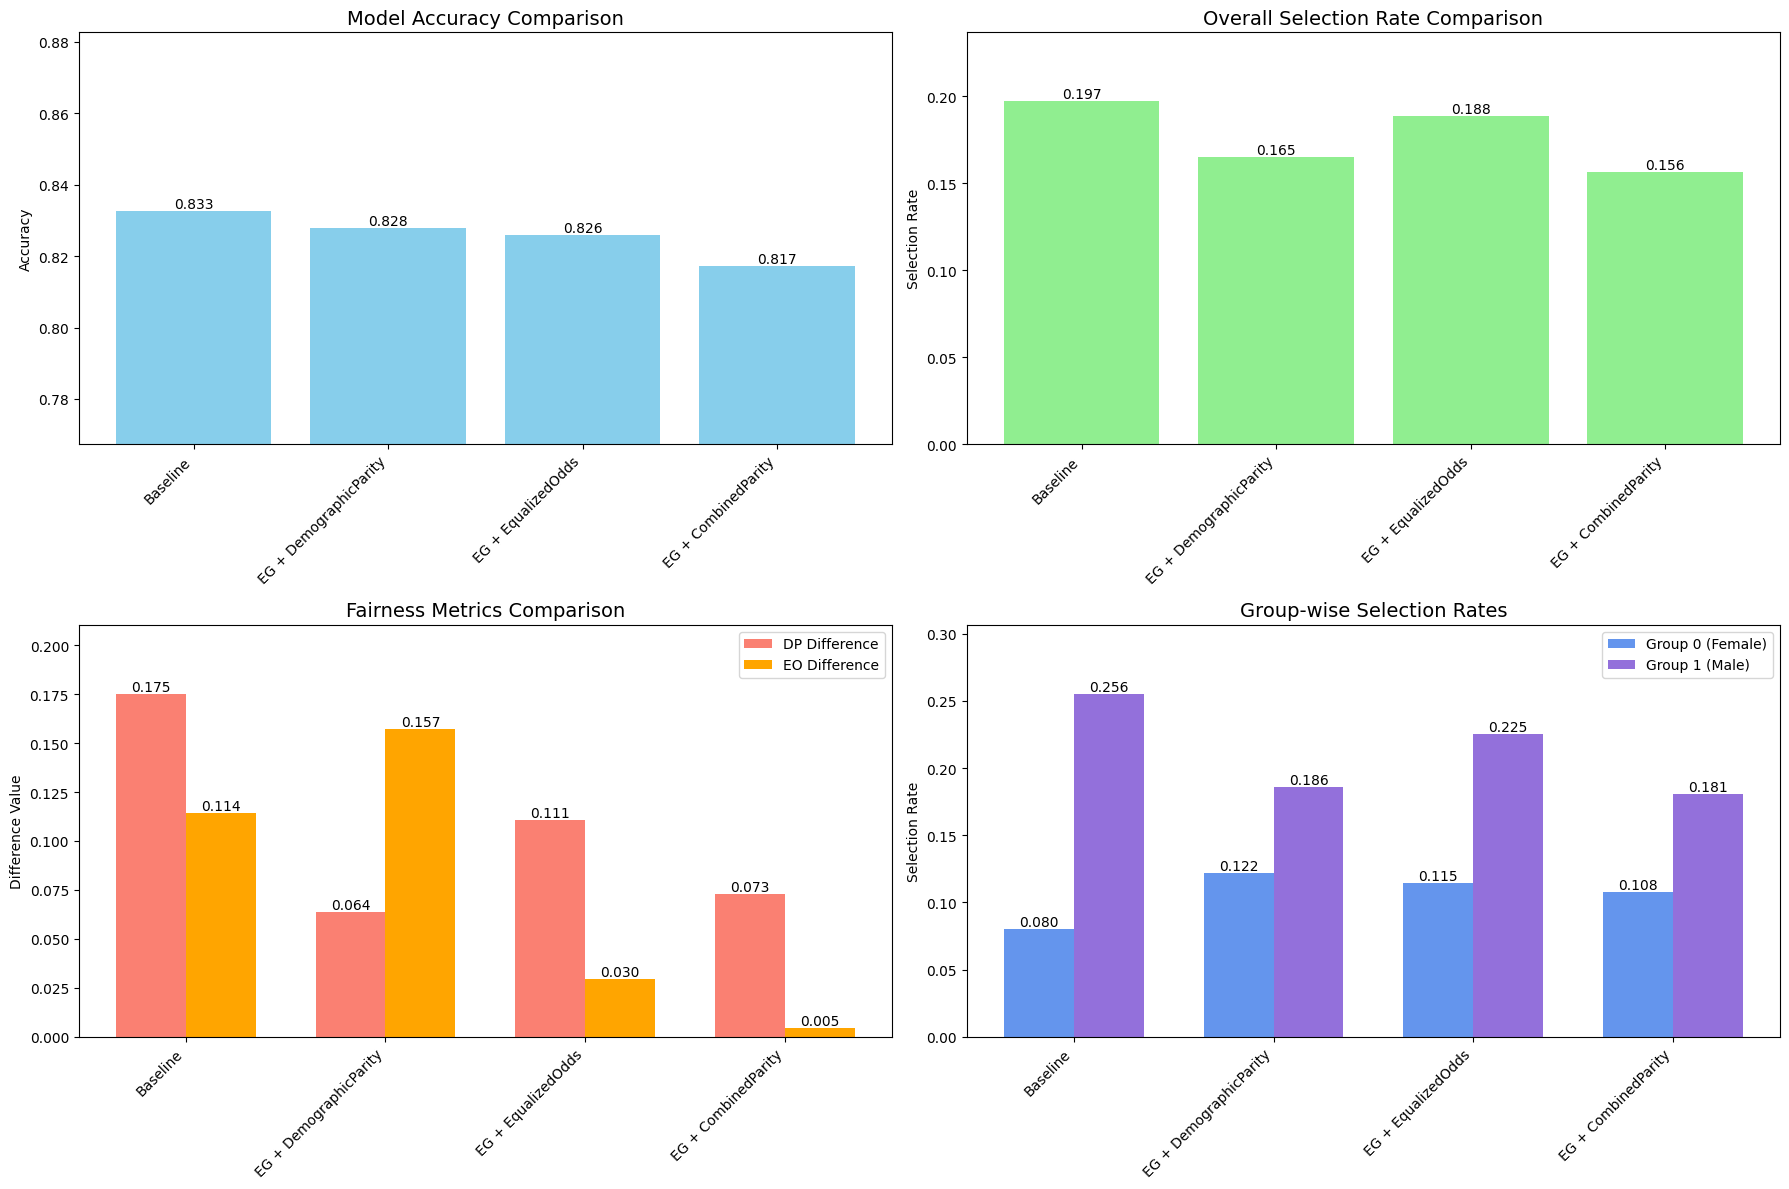

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create results DataFrame dynamically
results = pd.DataFrame({
    'Method': ["Baseline", "EG + DemographicParity", "EG + EqualizedOdds", "EG + CombinedParity"],
    'Accuracy': [
        mf_baseline.overall["accuracy"],
        mf_egr_dp.overall["accuracy"],
        mf_egr_eo.overall["accuracy"],
        mf_egr_fair.overall["accuracy"]
    ],
    'Selection_Rate': [
        mf_baseline.overall["selection_rate"],
        mf_egr_dp.overall["selection_rate"],
        mf_egr_eo.overall["selection_rate"],
        mf_egr_fair.overall["selection_rate"]
    ],
    'DP_Difference': [dp_diff_baseline, dp_diff_egr_dp, dp_diff_egr_eo, dp_diff_egr_fair],
    'EO_Difference': [eo_diff_baseline, eo_diff_egr_dp, eo_diff_egr_eo, eo_diff_egr_fair]
})

# Dynamic group rates extraction
def get_group_rates(mf):
    try:
        return mf.by_group.loc[0.0]["selection_rate"], mf.by_group.loc[1.0]["selection_rate"]
    except:
        # Fallback for different group labels if needed
        return mf.by_group.iloc[0]["selection_rate"], mf.by_group.iloc[1]["selection_rate"]

group_rates = pd.DataFrame({
    'Method': results['Method'],
    'Group 0 Rate': [
        get_group_rates(mf_baseline)[0],
        get_group_rates(mf_egr_dp)[0],
        get_group_rates(mf_egr_eo)[0],
        get_group_rates(mf_egr_fair)[0]
    ],
    'Group 1 Rate': [
        get_group_rates(mf_baseline)[1],
        get_group_rates(mf_egr_dp)[1],
        get_group_rates(mf_egr_eo)[1],
        get_group_rates(mf_egr_fair)[1]
    ]
})

# Create figure with dynamic scaling
plt.figure(figsize=(18, 12))

# 1. Accuracy Plot
plt.subplot(2, 2, 1)
bars = plt.bar(results['Method'], results['Accuracy'], color='skyblue')
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(max(0, min(results['Accuracy']) - 0.05), min(1, max(results['Accuracy']) + 0.05))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')

# 2. Selection Rate Plot
plt.subplot(2, 2, 2)
bars = plt.bar(results['Method'], results['Selection_Rate'], color='lightgreen')
plt.title('Overall Selection Rate Comparison', fontsize=14)
plt.ylabel('Selection Rate')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, min(1, max(results['Selection_Rate']) * 1.2))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')

# 3. Fairness Metrics Plot
plt.subplot(2, 2, 3)
x = np.arange(len(results))
width = 0.35
max_fairness = max(max(results['DP_Difference']), max(results['EO_Difference']))
plt.bar(x - width/2, results['DP_Difference'], width, label='DP Difference', color='salmon')
plt.bar(x + width/2, results['EO_Difference'], width, label='EO Difference', color='orange')
plt.title('Fairness Metrics Comparison', fontsize=14)
plt.ylabel('Difference Value')
plt.xticks(x, results['Method'], rotation=45, ha='right')
plt.legend()
plt.ylim(0, max_fairness * 1.2)
for i, (dp, eo) in enumerate(zip(results['DP_Difference'], results['EO_Difference'])):
    plt.text(i - width/2, dp, f'{dp:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, eo, f'{eo:.3f}', ha='center', va='bottom')

# 4. Group-wise Rates Plot
plt.subplot(2, 2, 4)
x = np.arange(len(group_rates))
width = 0.35
max_rate = max(group_rates['Group 0 Rate'].max(), group_rates['Group 1 Rate'].max())
plt.bar(x - width/2, group_rates['Group 0 Rate'], width, label='Group 0 (Female)', color='cornflowerblue')
plt.bar(x + width/2, group_rates['Group 1 Rate'], width, label='Group 1 (Male)', color='mediumpurple')
plt.title('Group-wise Selection Rates', fontsize=14)
plt.ylabel('Selection Rate')
plt.xticks(x, group_rates['Method'], rotation=45, ha='right')
plt.legend()
plt.ylim(0, max_rate * 1.2)
for i, (g0, g1) in enumerate(zip(group_rates['Group 0 Rate'], group_rates['Group 1 Rate'])):
    plt.text(i - width/2, g0, f'{g0:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, g1, f'{g1:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('fairness_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Our proposed code for Generalized the simple version(for Binary and multi-class)
# ------------------------
# Imports and constants
# ------------------------
import pandas as pd
import numpy as np
from fairlearn.reductions._moments.moment import ClassificationMoment
from fairlearn.reductions._moments.moment import _GROUP_ID, _LABEL, _PREDICTION, _ALL, _EVENT, _SIGN
from fairlearn.utils._input_validation import _validate_and_reformat_input, _MESSAGE_RATIO_NOT_IN_RANGE
_UPPER_BOUND_DIFF = "upper_bound_diff"
_LOWER_BOUND_DIFF = "lower_bound_diff"
_MESSAGE_INVALID_BOUNDS = "Only one of difference_bound and ratio_bound can be used."
_DEFAULT_DIFFERENCE_BOUND = 0.01
_CTRL_EVENT_FORMAT = "control={0},{1}"

# ------------------------
# Helper functions
# ------------------------
def _combine_event_and_control(event: str, control: str) -> str:
    if pd.notnull(control):
        return _CTRL_EVENT_FORMAT.format(control, event)
    else:
        return event

def _merge_event_and_control_columns(event_col, control_col):
    if control_col is None:
        return event_col
    else:
        return event_col.combine(control_col, _combine_event_and_control)
# ------------------------
# General Error Rate class
# -------------------
class GeneralErrorRate1(ClassificationMoment):
    """Misclassification error for both binary and multi-class classification."""

    short_name = "GenErr1"

    def __init__(self, y_p=1):
        super().__init__()
        self.y_p = y_p

    def load_data(self, X, y, *, sensitive_features, control_features=None):
        """Load the specified data into the object."""
        _, y_train, sf_train, cf_train = _validate_and_reformat_input(
            X, y,
            sensitive_features=sensitive_features,
            control_features=control_features
        )
        super().load_data(X, y_train, sensitive_features=sf_train)
        self.index = [_ALL]

    def gamma(self, predictor):
        """Return the misclassification error rate of the predictor."""
        pred = predictor(self.X)
        if isinstance(pred, np.ndarray):
            pred = np.squeeze(pred)
        error = pd.Series(data=(self.tags[_LABEL] != pred).mean(), index=self.index)
        self._gamma_descr = str(error)
        self.tags[_PREDICTION] = pred  # Needed for signed_weights
        return error

    def project_lambda(self, lambda_vec):
        """Return the lambda values (no projection needed)."""
        return lambda_vec

    def signed_weights(self, lambda_vec=None):
        """Return signed weights for binary or multi-class using positive label self.y_p."""
        y = self.tags[_LABEL]

        indicator = (y == self.y_p).astype(float)
        weights = 2 * indicator - 1

        if lambda_vec is None:
            return weights
        else:
            return lambda_vec[_ALL] * weights

# ------------------------
# General Utility Builder (multi-class)
# ------------------------
def build_pred_based_utilities(y: pd.Series, y_p: int) -> np.ndarray:
    classes = sorted(y.unique())
    n_classes = len(classes)
    n_samples = len(y)

    utilities = np.zeros((n_samples, n_classes), dtype=np.float64)
    for i, cls in enumerate(classes):
        if cls == y_p:
            utilities[:, i] = 1.0  # utility = 1 if prediction == y_p
    return utilities

# ------------------------
# GeneralUtilityParity class (multi-class and Binary)
# ------------------------
class GeneralUtilityParity1(ClassificationMoment):
    def __init__(self, *, difference_bound=None, ratio_bound=None, ratio_bound_slack=0.0, y_p=None):
        super(GeneralUtilityParity1, self).__init__()
        self.y_p = y_p
        if (difference_bound is None) and (ratio_bound is None):
            self.eps = _DEFAULT_DIFFERENCE_BOUND
            self.ratio = 1.0
        elif (difference_bound is not None) and (ratio_bound is None):
            self.eps = difference_bound
            self.ratio = 1.0
        elif (difference_bound is None) and (ratio_bound is not None):
            self.eps = ratio_bound_slack
            if not (0 < ratio_bound <= 1):
                raise ValueError(_MESSAGE_RATIO_NOT_IN_RANGE)
            self.ratio = ratio_bound
        else:
            raise ValueError(_MESSAGE_INVALID_BOUNDS)

    def default_objective(self):
        return GeneralErrorRate1(y_p=self.y_p)

    def load_data(self, X, y: pd.Series, *, sensitive_features: pd.Series, event: pd.Series = None, utilities=None):
        super().load_data(X, y, sensitive_features=sensitive_features)
        self.tags[_EVENT] = event

        # ===> Generalized utility matrix based on y_p
        if utilities is None:
            if self.y_p is None:
                raise ValueError("y_p must be specified to build the utility matrix")
            utilities = build_pred_based_utilities(y, y_p=self.y_p)

        self.utilities = utilities

        self.classes_ = sorted(np.unique(self.tags[_LABEL]))
        self.y_p_index = self.classes_.index(self.y_p)

        self.prob_event = self.tags.groupby(_EVENT).size() / self.total_samples
        self.prob_group_event = self.tags.groupby([_EVENT, _GROUP_ID]).size() / self.total_samples
        signed = pd.concat([self.prob_group_event, self.prob_group_event],
                           keys=["+", "-"],
                           names=[_SIGN, _EVENT, _GROUP_ID])
        self.index = signed.index
        self.default_objective_lambda_vec = None

        event_vals = self.tags[_EVENT].dropna().unique()
        group_vals = self.tags[_GROUP_ID].unique()
        self.pos_basis = pd.DataFrame(index=self.index)
        self.neg_basis = pd.DataFrame(index=self.index)
        self.neg_basis_present = pd.Series(dtype='float64')
        zero_vec = pd.Series(0.0, self.index)
        i = 0
        for event_val in event_vals:
            for group in group_vals[:-1]:
                self.pos_basis[i] = 0 + zero_vec
                self.neg_basis[i] = 0 + zero_vec
                self.pos_basis.loc[("+", event_val, group), i] = 1
                self.neg_basis.loc[("-", event_val, group), i] = 1
                self.neg_basis_present.at[i] = True
                i += 1

    def gamma(self, predictor):
        predictions = predictor(self.X)
        predictions = np.squeeze(predictions)
        pred = (predictions == self.y_p).astype(float)
        self.tags[_PREDICTION] = pred

        expect_event = self.tags.groupby(_EVENT)[[_PREDICTION]].mean()
        expect_group_event = self.tags.groupby([_EVENT, _GROUP_ID])[_PREDICTION].mean().to_frame()

        expect_group_event[_UPPER_BOUND_DIFF] = (
            self.ratio * expect_group_event[_PREDICTION] -
            expect_event[_PREDICTION].reindex(expect_group_event.index.get_level_values(0)).values
        )
        expect_group_event[_LOWER_BOUND_DIFF] = (
            - expect_group_event[_PREDICTION] +
            self.ratio * expect_event[_PREDICTION].reindex(expect_group_event.index.get_level_values(0)).values
        )

        g_signed = pd.concat(
            [expect_group_event[_UPPER_BOUND_DIFF], expect_group_event[_LOWER_BOUND_DIFF]],
            keys=["+", "-"],
            names=[_SIGN, _EVENT, _GROUP_ID]
        )

        self._gamma_descr = str(expect_group_event[[_PREDICTION, _UPPER_BOUND_DIFF, _LOWER_BOUND_DIFF]])
        return g_signed

    def bound(self):
        return pd.Series(self.eps, index=self.index)

    def project_lambda(self, lambda_vec):
        if self.ratio == 1.0:
            lambda_pos = lambda_vec["+"] - lambda_vec["-"]
            lambda_neg = -lambda_pos
            lambda_pos[lambda_pos < 0.0] = 0.0
            lambda_neg[lambda_neg < 0.0] = 0.0
            return pd.concat([lambda_pos, lambda_neg], keys=["+", "-"], names=[_SIGN, _EVENT, _GROUP_ID])
        return lambda_vec

    def signed_weights(self, lambda_vec):
        lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).groupby(level=_EVENT).sum() / self.prob_event
        lambda_group_event = (self.ratio * lambda_vec["+"] - lambda_vec["-"]) / self.prob_group_event
        adjust = lambda_event.reindex(lambda_group_event.index.get_level_values(0)).values - lambda_group_event.values
        adjust_series = pd.Series(adjust, index=lambda_group_event.index)

        signed_weights = self.tags.apply(
            lambda row: 0 if pd.isna(row[_EVENT]) else adjust_series[row[_EVENT], row[_GROUP_ID]], axis=1
        )

        utility_diff = self.utilities[:, self.y_p_index]
        return utility_diff * signed_weights

# ---------------------------------------------------------------------------------
#  General DemographicParity1 class, can works for binary and multi-class using y_P
# ---------------------------------------------------------------------------------
class GeneralDemographicParity1(GeneralUtilityParity1):
    short_name = "GeneralDemographicParity1"

    def __init__(self, *, y_p=None, difference_bound=None):
        super().__init__(y_p=y_p,difference_bound=difference_bound)

    def load_data(self, X, y, *, sensitive_features, control_features=None):
        _, y_train, sf_train, cf_train = _validate_and_reformat_input(
            X, y,
            sensitive_features=sensitive_features,
            control_features=control_features
        )
        base_event = pd.Series(data=_ALL, index=y_train.index)
        event = _merge_event_and_control_columns(base_event, cf_train)
        super().load_data(X, y_train, event=event, sensitive_features=sf_train)

# ------------------------------------------------------------------------------------
#  General EqualizedOdds1 class
# ------------------------------------------------------------------------------------
class GeneralEqualizedOdds1(GeneralUtilityParity1):
    short_name = "GeneralEqualizedOdds1"

    def __init__(self, *, y_p=None, difference_bound=None):
        super().__init__(y_p=y_p,difference_bound=difference_bound)

    def load_data(self, X, y, *, sensitive_features, control_features=None):
        _, y_train, sf_train, cf_train = _validate_and_reformat_input(
            X,
            y,
            sensitive_features=sensitive_features,
            control_features=control_features
        )

        # Define the event as the label itself: for each y_i, event = "label=y_i"
        base_event = y_train.apply(lambda v: _LABEL + "=" + str(v))
        event = _merge_event_and_control_columns(base_event, cf_train)

        super().load_data(X, y_train, event=event, sensitive_features=sf_train)


In [ ]:
# My new modifications at the ExponentiatedGradient to improve the accuracy

# =====================
# CONSTANTS DEFINITIONS
# =====================
_PRECISION = 1e-8
_LINE = "_" * 9
_INDENTATION = " " * 9

# Multiplier used to compute nu (threshold on duality gap)
_ACCURACY_MUL = 0.5

# Parameters for learning rate shrinking
_REGRET_CHECK_START_T = 5
_REGRET_CHECK_INCREASE_T = 1.6
_SHRINK_REGRET = 0.8
_SHRINK_ETA = 0.8

# Minimum number of iterations before termination is considered
_MIN_ITER = 5

# =====================================
# LAGRANGIAN CLASS AND HELPER CLASSES
# =====================================

import logging
from collections.abc import Callable
from time import time
import numpy as np
import pandas as pd
import scipy.optimize as opt
from sklearn import clone
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, MetaEstimatorMixin
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_is_fitted

from fairlearn.reductions._moments import ClassificationMoment
from fairlearn.reductions._moments.moment import Moment

logger = logging.getLogger(__name__)

_MESSAGE_BAD_OBJECTIVE = (
    "Objective needs to be of the same type as constraints. Objective is {}, constraints are {}."
)

#==============================================================================
# This class wraps any sklearn classifier so we can use it like a function h(X)
# Instead of writing clf.predict(X), we just write h(X)
#==============================================================================
class _PredictorAsCallable:
    def __init__(self, classifier):
        self._classifier = classifier

    def __call__(self, X):
        return self._classifier.predict(X)

#===============================================================================
# This class stores the Lagrangian value and its upper and lower bounds,
# along with the constraint violation (gamma) and error.
# It is used to compute the duality gap ν_t as defined in Algorithm 1
#================================================================================
class _GapResult:
    def __init__(self, L, L_low, L_high, gamma, error):
        self.L = L                # Current Lagrangian value: L( Q̄_t, λ̄_t )
        self.L_low = L_low        # Lower bound on the Lagrangian
        self.L_high = L_high      # Upper bound on the Lagrangian
        self.gamma = gamma        # Constraint violation vector
        self.error = error        # Objective value (e.g., classification error)

    def gap(self):
        # Duality gap: ν_t = max{ L - L_low, L_high - L }
        return max(self.L - self.L_low, self.L_high - self.L)

#==============================================================================
# Lagrangian object encapsulates the fairness optimization problem:
#   L(h, λ) = error(h) + Σ λ_j (γ_j(h) - b_j)
# It tracks all trained classifiers h, their errors, constraint violations (gamma),
# and λ vectors used for training. It also manages data loading and logging stats.
#==================================================================================
class _Lagrangian:
    def __init__(self, *, X, y, estimator, constraints: Moment, B: float, objective: Moment | None = None, opt_lambda: bool = True, sample_weight_name: str = "sample_weight", **kwargs):
        self.constraints = constraints
        self.constraints.load_data(X, y, **kwargs)
        if objective is None:
            self.obj = self.constraints.default_objective()
        elif objective._moment_type() == constraints._moment_type():
            self.obj = objective
        else:
            raise ValueError(_MESSAGE_BAD_OBJECTIVE.format(objective._moment_type(), constraints._moment_type()))
        self.obj.load_data(X, y, **kwargs)
        self.estimator = estimator
        self.B = B
        self.opt_lambda = opt_lambda

        self.hs = pd.Series(dtype="object")
        self.predictors = pd.Series(dtype="object")
        self.errors = pd.Series(dtype="float64")
        self.gammas = pd.DataFrame()
        self.lambdas = pd.DataFrame()
        self.n_oracle_calls = 0
        self.oracle_execution_times = []
        self.n_oracle_calls_dummy_returned = 0
        self.last_linprog_n_hs = 0
        self.last_linprog_result = None
        self.sample_weight_name = sample_weight_name

#============================================================================
# This function implements the empirical Lagrangian:
#   L(Q, λ) = error(Q) + λᵀ (gamma(Q) - bound)
# where Q is either:
#   - a single classifier h: X → {0,1,...,K}, or
#   - a randomized classifier (i.e., a distribution over classifiers)
#
# This corresponds to equation (3) from the paper:
#   min_Q err(Q)  s.t. M θ(Q) ≤ c
# by using Lagrangian relaxation to combine the objective and constraints.
#=======================================================================================
    def _eval(self, Q, lambda_vec):
        if callable(Q):
            error = self.obj.gamma(Q).iloc[0]
            gamma = self.constraints.gamma(Q)
        else:
            error = self.errors[Q.index].dot(Q)
            gamma = self.gammas[Q.index].dot(Q)
        if self.opt_lambda:
            lambda_vec = self.constraints.project_lambda(lambda_vec)
        L = error + np.sum(lambda_vec * (gamma - self.constraints.bound()))
        max_constraint = (gamma - self.constraints.bound()).max()
        L_high = error
        if max_constraint > 0:
            L_high += self.B * max_constraint
        return L, L_high, gamma, error

#============================================
# Evaluate the duality gap for a given Q and λ:
#   gap = max{ L(Q, λ) - L_low, L_high - L(Q, λ) }
# Starts with current Q and λ to compute L and L_high.
# Then searches for a better lower bound by training new h's
# using scaled versions of λ: mul * λ.
# If any h leads to lower L, updates L_low.
# Stops early if the gap becomes sufficiently large.
#===================================================
    def eval_gap(self, Q, lambda_hat, nu):
        L, L_high, gamma, error = self._eval(Q, lambda_hat)
        result = _GapResult(L, L, L_high, gamma, error)
        for mul in [1.0, 2.0, 5.0, 10.0]:
            _, h_hat_idx = self.best_h(mul * lambda_hat)
            logger.debug("%smul=%.0f", _INDENTATION, mul)
            L_low_mul, _, _, _ = self._eval(pd.Series({h_hat_idx: 1.0}), lambda_hat)
            if L_low_mul < result.L_low:
                result.L_low = L_low_mul
            if result.gap() > nu + _PRECISION:
                break
        return result

#================================================
# Solve a linear program to find the best randomized classifier Q over existing h's,
# minimizing the Lagrangian objective under fairness constraints.
#
# The primal LP optimizes:
#   min_Q   ∑ Q[i] * error(h_i) + B * η
#   s.t.    gamma(Q) - bound ≤ η
#           ∑ Q[i] = 1
#
# The dual LP is solved to obtain lambda_vec (Lagrange multipliers).
# Returns: (Q, lambda_vec, gap_result)
# The best λ-response to a given Q (BEST_λ(Q)) corresponds to placing all weight B
#================================================
    def solve_linprog(self, nu):
        n_hs = len(self.hs)
        n_constraints = len(self.constraints.index)
        if self.last_linprog_n_hs == n_hs:
            return self.last_linprog_result
        c = np.concatenate((self.errors, [self.B]))
        A_ub = np.concatenate((self.gammas.sub(self.constraints.bound(), axis=0), -np.ones((n_constraints, 1))), axis=1)
        b_ub = np.zeros(n_constraints)
        A_eq = np.concatenate((np.ones((1, n_hs)), np.zeros((1, 1))), axis=1)
        b_eq = np.ones(1)
        result = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, method="highs-ds")
        Q = pd.Series(result.x[:-1], self.hs.index)
        dual_c = np.concatenate((b_ub, -b_eq))
        dual_A_ub = np.concatenate((-A_ub.transpose(), A_eq.transpose()), axis=1)
        dual_b_ub = c
        dual_bounds = [(None, None) if i == n_constraints else (0, None) for i in range(n_constraints + 1)]
        result_dual = opt.linprog(dual_c, A_ub=dual_A_ub, b_ub=dual_b_ub, bounds=dual_bounds, method="highs-ds")
        lambda_vec = pd.Series(result_dual.x[:-1], self.constraints.index)
        self.last_linprog_n_hs = n_hs
        self.last_linprog_result = (Q, lambda_vec, self.eval_gap(Q, lambda_vec, nu))
        return self.last_linprog_result

# ===============================
# Oracle: trains a classifier h in response to the current λ vector.
# Computes signed weights combining accuracy loss and fairness constraint violations.
# Generate new training labels (redY) based on fairness constraints
# ===============================
    def _call_oracle(self, lambda_vec):
        signed_weights = self.obj.signed_weights() + self.constraints.signed_weights(lambda_vec)
        signed_y = self.constraints._y_as_series.copy()
        signed_weight_series = signed_weights.copy()
        unique_classes = np.sort(np.unique(signed_y))

        if len(unique_classes) == 2:
            # Binary classification
            redY = pd.Series(
                np.where(signed_weight_series > 0, unique_classes[1], unique_classes[0]),
                index=signed_y.index
            )
        else:
            # Multi-class classification
            redY = pd.Series(
                np.where(signed_weight_series > 0, self.constraints.y_p, signed_y),
                index=signed_y.index
            )

        redW = signed_weight_series.abs()
        redW = self.constraints.total_samples * redW / redW.sum() # normalization
        redY_unique = np.unique(redY)

        # Train the estimator (oracle) using redY and redW
        if len(redY_unique) == 1:
            logger.debug("redY had single value. Using DummyClassifier")
            estimator = DummyClassifier(strategy="constant", constant=redY_unique[0])
            self.n_oracle_calls_dummy_returned += 1
        else:
            estimator = clone(estimator=self.estimator, safe=False)

        oracle_call_start_time = time()
        estimator.fit(self.constraints.X, redY, **{self.sample_weight_name: redW})
        self.oracle_execution_times.append(time() - oracle_call_start_time)
        self.n_oracle_calls += 1
        return estimator

# =========================================================
# best_h: Computes the best classifier h for current lambda
# ---------------------------------------------------------
# - Trains a new classifier using _call_oracle(lambda_vec)
# - Computes its error and fairness violation (gamma)
# - Evaluates its Lagrangian value: error + lambda^T * gamma
# - If this classifier improves the current best, we store it
# - Returns the best classifier (among all iterations so far)
# =========================================================
    def best_h(self, lambda_vec):
        classifier = self._call_oracle(lambda_vec)
        h = _PredictorAsCallable(classifier)
        h_error = self.obj.gamma(h).iloc[0]
        h_gamma = self.constraints.gamma(h)
        h_value = h_error + h_gamma.dot(lambda_vec)
        if not self.hs.empty:
            values = self.errors + self.gammas.transpose().dot(lambda_vec)
            best_idx = values.idxmin()
            best_value = values[best_idx]
        else:
            best_idx = -1
            best_value = np.inf
        if h_value < best_value - _PRECISION:
            logger.debug("%sbest_h: val improvement %f", _LINE, best_value - h_value)
            h_idx = len(self.hs)
            self.hs.at[h_idx] = h
            self.predictors.at[h_idx] = classifier
            self.errors.at[h_idx] = h_error
            self.gammas[h_idx] = h_gamma
            self.lambdas[h_idx] = lambda_vec.copy()
            best_idx = h_idx
        return self.hs[best_idx], best_idx

# =====================================
# EXPONENTIATED GRADIENT CLASS (full)
# =====================================

class ExponentiatedGradient2(BaseEstimator, MetaEstimatorMixin):
    def __init__(
        self,
        estimator,
        constraints: Moment,
        *,
        objective: Moment | None = None,
        eps: float = 0.01,
        max_iter: int = 50,
        nu: float | None = None,
        eta0: float = 2.0,
        run_linprog_step: bool = True,
        sample_weight_name: str = "sample_weight",
        positive_label=1,
    ):
        self.estimator = estimator
        self.constraints = constraints
        self.objective = objective
        self.eps = eps
        self.max_iter = max_iter
        self.nu = nu
        self.eta0 = eta0
        self.run_linprog_step = run_linprog_step
        self.sample_weight_name = sample_weight_name
        self.positive_label = positive_label

    def fit(self, X, y, **kwargs):
        self.lambda_vecs_EG_ = pd.DataFrame()
        self.lambda_vecs_LP_ = pd.DataFrame()

        logger.debug("...Exponentiated Gradient STARTING")

        B = 1 / self.eps
        lagrangian = _Lagrangian(
            X=X,
            y=y,
            estimator=self.estimator,
            constraints=self.constraints,
            B=B,
            objective=self.objective,
            sample_weight_name=self.sample_weight_name,
            **kwargs,
        )

        theta = pd.Series(0, lagrangian.constraints.index)
        Qsum = pd.Series(dtype="float64")
        gaps_EG = []
        gaps = []
        Qs = []

        last_regret_checked = _REGRET_CHECK_START_T
        last_gap = np.inf

        for t in range(self.max_iter):
            logger.debug("...iter=%03d", t)

            lambda_vec = B * np.exp(theta) / (1 + np.exp(theta).sum())
            self.lambda_vecs_EG_[t] = lambda_vec
            lambda_EG = self.lambda_vecs_EG_.mean(axis=1)

            h, h_idx = lagrangian.best_h(lambda_vec)

            if t == 0:
                if self.nu is None:
                    self.nu = (
                        _ACCURACY_MUL
                        * (h(X) - self.constraints._y_as_series).abs().std()
                        / np.sqrt(self.constraints.total_samples)
                    )
                eta = self.eta0 / B
                logger.debug("...eps=%.3f, B=%.1f, nu=%.6f, max_iter=%d", self.eps, B, self.nu, self.max_iter)

            if h_idx not in Qsum.index:
                Qsum.at[h_idx] = 0.0
            Qsum[h_idx] += 1.0
            gamma = lagrangian.gammas[h_idx]
            Q_EG = Qsum / Qsum.sum()
            result_EG = lagrangian.eval_gap(Q_EG, lambda_EG, self.nu)
            gap_EG = result_EG.gap()
            gaps_EG.append(gap_EG)

            if t == 0 or not self.run_linprog_step:
                gap_LP = np.inf
            else:
                Q_LP, self.lambda_vecs_LP_[t], result_LP = lagrangian.solve_linprog(self.nu)
                gap_LP = result_LP.gap()

            if gap_EG < gap_LP:
                Qs.append(Q_EG)
                gaps.append(gap_EG)
            else:
                Qs.append(Q_LP)
                gaps.append(gap_LP)

            logger.debug("%seta=%.6f, gap=%.6f, gap_LP=%.6f", _INDENTATION, eta, gap_EG, gap_LP)

            if (gaps[t] < self.nu) and (t >= _MIN_ITER):
                break

            if t >= last_regret_checked * _REGRET_CHECK_INCREASE_T:
                best_gap = min(gaps_EG)
                if best_gap > last_gap * _SHRINK_REGRET:
                    eta *= _SHRINK_ETA
                last_regret_checked = t
                last_gap = best_gap

            theta += eta * (gamma - self.constraints.bound())

        gaps_series = pd.Series(gaps)
        gaps_best = gaps_series[gaps_series <= gaps_series.min() + _PRECISION]
        self.best_iter_ = gaps_best.index[-1]
        self.best_gap_ = gaps[self.best_iter_]
        self.weights_ = Qs[self.best_iter_]
        self._hs = lagrangian.hs

        # Ensure all classifiers have weights (even if zero)
        for h_idx in self._hs.index:
            if h_idx not in self.weights_.index:
                self.weights_.at[h_idx] = 0.0

        # Normalize weights to sum to 1
        self.weights_ = self.weights_ / self.weights_.sum()

        self.last_iter_ = len(Qs) - 1
        self.predictors_ = lagrangian.predictors
        self.n_oracle_calls_ = lagrangian.n_oracle_calls
        self.n_oracle_calls_dummy_returned_ = lagrangian.n_oracle_calls_dummy_returned
        self.oracle_execution_times_ = lagrangian.oracle_execution_times
        self.lambda_vecs_ = lagrangian.lambdas

        return self

    def _pmf_predict(self, X):
        check_is_fitted(self)

        # Get all unique classes first by collecting predictions from all classifiers
        all_classes = set()
        for t in self._hs.index:
            pred = self._hs[t](X)
            all_classes.update(pred)
        all_classes = np.sort(np.array(list(all_classes)))

        # Initialize probability matrix
        class_probs = np.zeros((len(X), len(all_classes)))

        # Calculate weighted probabilities
        for t in self._hs.index:
            pred = self._hs[t](X)
            for i, c in enumerate(all_classes):
                class_probs[:, i] += (pred == c).astype(float) * self.weights_[t]

        return class_probs

    def predict(self, X, random_state=None):
        check_is_fitted(self)
        random_state = check_random_state(random_state)
        probs = self._pmf_predict(X)

        # Find the index of the positive label
        all_classes = np.unique([self._hs[t](X) for t in self._hs.index])
        positive_label_idx = np.where(all_classes == self.positive_label)[0]
        if len(positive_label_idx) == 0:
            raise ValueError(f"Positive label {self.positive_label} not found in predicted classes")
        positive_label_idx = positive_label_idx[0]

        predictions = []
        for i in range(len(X)):
            r = random_state.rand()
            if probs[i, positive_label_idx] >= r:
                predictions.append(self.positive_label)
            else:
                # For other classes, sample according to remaining probability
                mask = np.ones(len(all_classes), dtype=bool)
                mask[positive_label_idx] = False
                other_probs = probs[i, mask]
                other_classes = all_classes[mask]
                if other_probs.sum() > 0:
                    other_probs = other_probs / other_probs.sum()
                    predictions.append(random_state.choice(other_classes, p=other_probs))
                else:
                    # If no probability left for other classes, default to positive label
                    predictions.append(self.positive_label)
        return np.array(predictions)

In [ ]:
# ========================
#  IMPORTS & SETUP
# ========================
import pandas as pd
import numpy as np
import logging
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    demographic_parity_difference,
    equalized_odds_difference
)


# Setup logger and warnings
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

# ========================
#  PART 1: BINARY CLASSIFICATION
# ========================
logger.info("Loading binary dataset: Adult")

# Load and preprocess dataset
df = pd.read_csv("/content/fairlearn_project/data/adult.csv")
X = df.drop(columns=["Unnamed: 0", "income", "sex"])
y = df["income"]
sensitive = df["sex"]

# Encode string labels
from sklearn.preprocessing import LabelEncoder
y = pd.Series(LabelEncoder().fit_transform(y), index=df.index, name="income")
sensitive = pd.Series(LabelEncoder().fit_transform(sensitive), index=df.index, name="sex")

# Split data into training and testing
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42
)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
s_train = s_train.reset_index(drop=True)
s_test = s_test.reset_index(drop=True)

# Baseline model (no fairness constraints)
baseline = LogisticRegression(solver="liblinear")
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)

acc_b = accuracy_score(y_test, y_pred_baseline)
dp_b = demographic_parity_difference(y_test, y_pred_baseline, sensitive_features=s_test)
eo_b = equalized_odds_difference(y_test, y_pred_baseline, sensitive_features=s_test)

# ExponentiatedGradient + DemographicParity1 (Simple version)
dp_model_simple = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=DemographicParity1(difference_bound=0.05),
    eps=1e-5
)
dp_model_simple.fit(X_train, y_train, sensitive_features=s_train)
y_pred_dp_simple = dp_model_simple.predict(X_test)

acc_dp_simple = accuracy_score(y_test, y_pred_dp_simple)
dp_dp_simple = demographic_parity_difference(y_test, y_pred_dp_simple, sensitive_features=s_test)
eo_dp_simple = equalized_odds_difference(y_test, y_pred_dp_simple, sensitive_features=s_test)

# ExponentiatedGradient + EqualizedOdds1 (Simple version)
eo_model_simple = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=EqualizedOdds1(difference_bound=0.05),
    eps=1e-5
)
eo_model_simple.fit(X_train, y_train, sensitive_features=s_train)
y_pred_eo_simple = eo_model_simple.predict(X_test)

acc_eo_simple = accuracy_score(y_test, y_pred_eo_simple)
dp_eo_simple = demographic_parity_difference(y_test, y_pred_eo_simple, sensitive_features=s_test)
eo_eo_simple = equalized_odds_difference(y_test, y_pred_eo_simple, sensitive_features=s_test)

# ExponentiatedGradient2 + GeneralDemographicParity1 (Full generalized version)
dp_model = ExponentiatedGradient2(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=GeneralDemographicParity1(y_p=1,difference_bound=0.05),
    eps=1e-5
)
dp_model.fit(X_train, y_train, sensitive_features=s_train)
y_pred_dp = dp_model.predict(X_test)

acc_dp = accuracy_score(y_test, y_pred_dp)
dp_dp = demographic_parity_difference(y_test, y_pred_dp, sensitive_features=s_test)
eo_dp = equalized_odds_difference(y_test, y_pred_dp, sensitive_features=s_test)

# ExponentiatedGradient2 + GeneralEqualizedOdds1 (Full generalized version)
eo_model = ExponentiatedGradient2(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=GeneralEqualizedOdds1(y_p=1,difference_bound=0.05),
    eps=1e-5
)
eo_model.fit(X_train, y_train, sensitive_features=s_train)
y_pred_eo = eo_model.predict(X_test)

acc_eo = accuracy_score(y_test, y_pred_eo)
dp_eo = demographic_parity_difference(y_test, y_pred_eo, sensitive_features=s_test)
eo_eo = equalized_odds_difference(y_test, y_pred_eo, sensitive_features=s_test)

# Combine all results
df_binary = pd.DataFrame([
    {"Model": "Baseline", "Accuracy": acc_b, "DP": dp_b, "EO": eo_b},
    {"Model": "DP Constraint (Simple)", "Accuracy": acc_dp_simple, "DP": dp_dp_simple, "EO": eo_dp_simple},
    {"Model": "EO Constraint (Simple)", "Accuracy": acc_eo_simple, "DP": dp_eo_simple, "EO": eo_eo_simple},
    {"Model": "DP Constraint (with y_p=1)", "Accuracy": acc_dp, "DP": dp_dp, "EO": eo_dp},
    {"Model": "EO Constraint (with y_p=1)", "Accuracy": acc_eo, "DP": dp_eo, "EO": eo_eo}
])

print("\n" + "="*60)
print(" FULL BINARY CLASSIFICATION RESULTS")
print("="*60)
print(df_binary.round(3))




 FULL BINARY CLASSIFICATION RESULTS
                        Model  Accuracy     DP     EO
0                    Baseline     0.833  0.175  0.114
1      DP Constraint (Simple)     0.828  0.064  0.158
2      EO Constraint (Simple)     0.833  0.140  0.054
3  DP Constraint (with y_p=1)     0.828  0.064  0.158
4  EO Constraint (with y_p=1)     0.833  0.140  0.054


In [ ]:
# ------------------------
# Imports and constants
# ------------------------
import pandas as pd
import numpy as np
from fairlearn.reductions._moments.moment import ClassificationMoment
from fairlearn.reductions._moments.moment import _GROUP_ID, _LABEL, _PREDICTION, _ALL, _EVENT, _SIGN
from fairlearn.utils._input_validation import _validate_and_reformat_input, _MESSAGE_RATIO_NOT_IN_RANGE

# Constants
_DEFAULT_DIFFERENCE_BOUND = 0.01
_UPPER_BOUND_DIFF = "upper_bound_diff"
_LOWER_BOUND_DIFF = "lower_bound_diff"
_MESSAGE_INVALID_BOUNDS = "Only one of difference_bound and ratio_bound can be used."

# ------------------------
# General Error Rate class
# ------------------------
class GeneralErrorRate1(ClassificationMoment):
    """Misclassification error for both binary and multi-class classification."""

    short_name = "GenErr1"

    def __init__(self, y_p=1):
        super().__init__()
        self.y_p = y_p

    def load_data(self, X, y, *, sensitive_features, control_features=None):
        """Load the specified data into the object."""
        _, y_train, sf_train, cf_train = _validate_and_reformat_input(
            X, y,
            sensitive_features=sensitive_features,
            control_features=control_features
        )
        super().load_data(X, y_train, sensitive_features=sf_train)
        self.index = [_ALL]

    def gamma(self, predictor):
        """Return the misclassification error rate of the predictor."""
        pred = predictor(self.X)
        if isinstance(pred, np.ndarray):
            pred = np.squeeze(pred)
        error = pd.Series(data=(self.tags[_LABEL] != pred).mean(), index=self.index)
        self._gamma_descr = str(error)
        self.tags[_PREDICTION] = pred  # Needed for signed_weights
        return error

    def project_lambda(self, lambda_vec):
        """Return the lambda values (no projection needed)."""
        return lambda_vec

    def signed_weights(self, lambda_vec=None):
        """Return signed weights for binary or multi-class using positive label self.y_p."""
        y = self.tags[_LABEL]

        indicator = (y == self.y_p).astype(float)
        weights = 2 * indicator - 1

        if lambda_vec is None:
            return weights
        else:
            return lambda_vec[_ALL] * weights

# ------------------------
# General Utility Builder (multi-class)
# ------------------------
def build_pred_based_utilities(y: pd.Series, y_p: int) -> np.ndarray:
    """Build utility matrix where utility=1 when prediction equals y_p."""
    classes = sorted(y.unique())
    n_classes = len(classes)
    n_samples = len(y)

    utilities = np.zeros((n_samples, n_classes), dtype=np.float64)
    for i, cls in enumerate(classes):
        if cls == y_p:
            utilities[:, i] = 1.0  # utility = 1 if prediction == y_p
    return utilities

# -----------------------------------------
# Combined Fairness Constraint Class (DP + EO)
# -----------------------------------------
class CombinedParityGeneral1(ClassificationMoment):
    """Combined demographic parity and equalized odds constraints for classification."""

    short_name = "CombinedParityGeneral1"

    def __init__(
        self,
        *,
        y_p,
        use_dp=True,
        use_eo=True,
        dp_bound=None,
        eo_bound=None,
        dp_ratio_bound=None,
        eo_ratio_bound=None,
        ratio_bound_slack=0.0,
    ):
        super().__init__()
        if not use_dp and not use_eo:
            raise ValueError("At least one of use_dp or use_eo must be True")
        if (dp_bound is not None and dp_ratio_bound is not None) or (eo_bound is not None and eo_ratio_bound is not None):
            raise ValueError(_MESSAGE_INVALID_BOUNDS)

        self.y_p = y_p
        self.use_dp = use_dp
        self.use_eo = use_eo
        self.dp_bound = dp_bound if dp_bound is not None else _DEFAULT_DIFFERENCE_BOUND
        self.eo_bound = eo_bound if eo_bound is not None else _DEFAULT_DIFFERENCE_BOUND
        self.dp_ratio_bound = dp_ratio_bound
        self.eo_ratio_bound = eo_ratio_bound
        self.ratio_bound_slack = ratio_bound_slack

    def default_objective(self):
        """Return the default objective (error rate)."""
        return GeneralErrorRate1(y_p=self.y_p)

    def load_data(self, X, y, *, sensitive_features, control_features=None, utilities=None):
        """Load the specified data into the object."""
        _, y_train, sf_train, cf_train = _validate_and_reformat_input(
            X, y,
            sensitive_features=sensitive_features,
            control_features=control_features
        )
        self.tags = pd.DataFrame({_LABEL: y_train, _GROUP_ID: sf_train})
        self.X = X
        self._y = y_train
        self._total_samples = len(y_train)

        # Build utilities if not provided
        if utilities is None:
            utilities = build_pred_based_utilities(y_train, self.y_p)
        self.utilities = utilities
        self.classes_ = sorted(np.unique(y_train))
        self.y_p_index = self.classes_.index(self.y_p)

        # Initialize events and bounds
        events = []
        bounds = []
        ratios = {}

        if self.use_dp:
            self.tags["dp_event"] = pd.Series(_ALL, index=y_train.index)
            events.append("dp_event")
            bounds.append(self.dp_bound)
            ratios["dp_event"] = self.dp_ratio_bound if self.dp_ratio_bound is not None else 1.0

        if self.use_eo:
            self.tags["eo_event"] = y_train.apply(lambda v: f"{_LABEL}={v}")
            events.append("eo_event")
            bounds.append(self.eo_bound)
            ratios["eo_event"] = self.eo_ratio_bound if self.eo_ratio_bound is not None else 1.0

        # Create index and probability distributions
        self.index = []
        bound_vals = []
        self.prob_event = {}
        self.prob_group_event = {}

        for ev_col, bound in zip(events, bounds):
            ev_vals = self.tags[ev_col].unique()
            self.prob_event[ev_col] = self.tags.groupby(ev_col).size() / self._total_samples
            self.prob_group_event[ev_col] = self.tags.groupby([ev_col, _GROUP_ID]).size() / self._total_samples

            for ev in ev_vals:
                for g in self.tags[_GROUP_ID].unique():
                    self.index.append(("+", ev, g))
                    self.index.append(("-", ev, g))
                    bound_vals.append(bound)
                    bound_vals.append(bound)

        self.index = pd.MultiIndex.from_tuples(self.index, names=[_SIGN, _EVENT, _GROUP_ID])
        self.bound_ = pd.Series(bound_vals, index=self.index)
        self.ratios = ratios

    def bound(self):
        """Return the bound values."""
        return self.bound_

    def gamma(self, predictor):
        """Calculate gamma values for the current predictor."""
        predictions = np.squeeze(predictor(self.X))
        pred = (predictions == self.y_p).astype(float)
        self.tags[_PREDICTION] = pred

        gamma_list = []
        for ev_col in ["dp_event", "eo_event"]:
            if ev_col not in self.tags.columns:
                continue

            ratio = self.ratios[ev_col]
            mean_event = self.tags.groupby(ev_col)[_PREDICTION].mean()
            mean_group_event = self.tags.groupby([ev_col, _GROUP_ID])[_PREDICTION].mean()

            upper = ratio * mean_group_event - mean_event.reindex(mean_group_event.index.get_level_values(0)).values
            lower = -mean_group_event + ratio * mean_event.reindex(mean_group_event.index.get_level_values(0)).values

            g = pd.concat([upper, lower], keys=["+", "-"], names=[_SIGN, _EVENT, _GROUP_ID])
            gamma_list.append(g)

        gamma_final = pd.concat(gamma_list).reindex(self.index).fillna(0)
        self._gamma_descr = str(gamma_final)
        return gamma_final

    def project_lambda(self, lambda_vec):
        """Project lambda values according to constraints."""
        dp_ratio_1 = (self.dp_ratio_bound is None or self.dp_ratio_bound == 1.0)
        eo_ratio_1 = (self.eo_ratio_bound is None or self.eo_ratio_bound == 1.0)

        if dp_ratio_1 and eo_ratio_1:
            lambda_pos = lambda_vec["+"] - lambda_vec["-"]
            lambda_neg = -lambda_pos
            lambda_pos[lambda_pos < 0.0] = 0.0
            lambda_neg[lambda_neg < 0.0] = 0.0
            return pd.concat([lambda_pos, lambda_neg], keys=["+", "-"], names=[_SIGN, _EVENT, _GROUP_ID])
        return lambda_vec

    def signed_weights(self, lambda_vec):
        """Compute signed weights for the classifier."""
        signed_weights = pd.Series(0.0, index=self.tags.index)

        for ev_col in ["dp_event", "eo_event"]:
            if ev_col not in self.tags.columns:
                continue

            ratio = self.ratios[ev_col]
            prob_e = self.prob_event[ev_col]
            prob_ge = self.prob_group_event[ev_col]

            lambda_event = (lambda_vec["+"] - ratio * lambda_vec["-"]).groupby(level=_EVENT).sum()
            lambda_group_event = (ratio * lambda_vec["+"] - lambda_vec["-"])

            for (e, g) in prob_ge.index:
                adjust = lambda_event[e] / prob_e[e] - lambda_group_event[(e, g)] / prob_ge[(e, g)]
                mask = (self.tags[ev_col] == e) & (self.tags[_GROUP_ID] == g)
                signed_weights[mask] += adjust

        utility_diff = self.utilities[:, self.y_p_index]
        return utility_diff * signed_weights

    def __repr__(self):
        return (
            f"CombinedParityGeneral1(y_p={self.y_p}, use_dp={self.use_dp}, use_eo={self.use_eo}, "
            f"dp_bound={self.dp_bound}, eo_bound={self.eo_bound}, "
            f"dp_ratio_bound={self.dp_ratio_bound}, eo_ratio_bound={self.eo_ratio_bound})"
        )

In [ ]:
# ========================
#  IMPORTS & SETUP
# ========================
import pandas as pd
import numpy as np
import logging
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference
)
# ========================
# LOGGING & WARNINGS
# ========================
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

# ========================
# LOAD BINARY DATASET
# ========================
logger.info("Loading binary dataset: Adult")
df = pd.read_csv("/content/fairlearn_project/data/adult.csv")
X = df.drop(columns=["Unnamed: 0", "income", "sex"])
y = df["income"]
sensitive = df["sex"]

# Encode labels
from sklearn.preprocessing import LabelEncoder
y = pd.Series(LabelEncoder().fit_transform(y), index=df.index, name="income")
sensitive = pd.Series(LabelEncoder().fit_transform(sensitive), index=df.index, name="sex")

# Split data
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42
)
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)
s_train, s_test = s_train.reset_index(drop=True), s_test.reset_index(drop=True)

# ========================
# BASELINE MODEL
# ========================
baseline = LogisticRegression(solver="liblinear")
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)
acc_b = accuracy_score(y_test, y_pred_baseline)
dp_b = demographic_parity_difference(y_test, y_pred_baseline, sensitive_features=s_test)
eo_b = equalized_odds_difference(y_test, y_pred_baseline, sensitive_features=s_test)

# ========================
# DP Constraint (Simple)
# ========================
dp_model_simple = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=DemographicParity1(difference_bound=0.05),
    eps=1e-5
)
dp_model_simple.fit(X_train, y_train, sensitive_features=s_train)
y_pred_dp_simple = dp_model_simple.predict(X_test)
acc_dp_simple = accuracy_score(y_test, y_pred_dp_simple)
dp_dp_simple = demographic_parity_difference(y_test, y_pred_dp_simple, sensitive_features=s_test)
eo_dp_simple = equalized_odds_difference(y_test, y_pred_dp_simple, sensitive_features=s_test)

# ========================
# EO Constraint (Simple)
# ========================
eo_model_simple = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=EqualizedOdds1(difference_bound=0.05),
    eps=1e-5
)
eo_model_simple.fit(X_train, y_train, sensitive_features=s_train)
y_pred_eo_simple = eo_model_simple.predict(X_test)
acc_eo_simple = accuracy_score(y_test, y_pred_eo_simple)
dp_eo_simple = demographic_parity_difference(y_test, y_pred_eo_simple, sensitive_features=s_test)
eo_eo_simple = equalized_odds_difference(y_test, y_pred_eo_simple, sensitive_features=s_test)

# ========================
# DP Constraint (General, y_p=1)
# ========================
dp_model = ExponentiatedGradient2(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=GeneralDemographicParity1(y_p=1, difference_bound=0.05),
    eps=1e-5
)
dp_model.fit(X_train, y_train, sensitive_features=s_train)
y_pred_dp = dp_model.predict(X_test)
acc_dp = accuracy_score(y_test, y_pred_dp)
dp_dp = demographic_parity_difference(y_test, y_pred_dp, sensitive_features=s_test)
eo_dp = equalized_odds_difference(y_test, y_pred_dp, sensitive_features=s_test)

# ========================
# EO Constraint (General, y_p=1)
# ========================
eo_model = ExponentiatedGradient2(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=GeneralEqualizedOdds1(y_p=1, difference_bound=0.05),
    eps=1e-5
)
eo_model.fit(X_train, y_train, sensitive_features=s_train)
y_pred_eo = eo_model.predict(X_test)
acc_eo = accuracy_score(y_test, y_pred_eo)
dp_eo = demographic_parity_difference(y_test, y_pred_eo, sensitive_features=s_test)
eo_eo = equalized_odds_difference(y_test, y_pred_eo, sensitive_features=s_test)

# ========================
# CombinedConstraint (DP+EO) General
# ========================
combo_model = ExponentiatedGradient2(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=CombinedParityGeneral1(use_dp=True,use_eo=True,y_p=1, dp_bound=0.05, eo_bound=0.05),
    eps=1e-5
)
combo_model.fit(X_train, y_train, sensitive_features=s_train)
y_pred_combo = combo_model.predict(X_test)
acc_combo = accuracy_score(y_test, y_pred_combo)
dp_combo = demographic_parity_difference(y_test, y_pred_combo, sensitive_features=s_test)
eo_combo = equalized_odds_difference(y_test, y_pred_combo, sensitive_features=s_test)

# ========================
# SHOW RESULTS
# ========================
df_binary = pd.DataFrame([
    {"Model": "Baseline", "Accuracy": acc_b, "DP": dp_b, "EO": eo_b},
    {"Model": "DP Constraint (Simple)", "Accuracy": acc_dp_simple, "DP": dp_dp_simple, "EO": eo_dp_simple},
    {"Model": "EO Constraint (Simple)", "Accuracy": acc_eo_simple, "DP": dp_eo_simple, "EO": eo_eo_simple},
    {"Model": "DP Constraint (with y_p=1)", "Accuracy": acc_dp, "DP": dp_dp, "EO": eo_dp},
    {"Model": "EO Constraint (with y_p=1)", "Accuracy": acc_eo, "DP": dp_eo, "EO": eo_eo},
    {"Model": "Combined DP+EO (y_p=1)", "Accuracy": acc_combo, "DP": dp_combo, "EO": eo_combo},
])

print("\n" + "="*60)
print(" FULL BINARY CLASSIFICATION RESULTS")
print("="*60)
print(df_binary.round(3))



 FULL BINARY CLASSIFICATION RESULTS
                        Model  Accuracy     DP     EO
0                    Baseline     0.833  0.175  0.114
1      DP Constraint (Simple)     0.828  0.064  0.158
2      EO Constraint (Simple)     0.833  0.140  0.054
3  DP Constraint (with y_p=1)     0.828  0.064  0.157
4  EO Constraint (with y_p=1)     0.833  0.140  0.054
5      Combined DP+EO (y_p=1)     0.819  0.063  0.083


In [ ]:
# ========================
#  PART 2: MULTI-CLASS CLASSIFICATION
# ========================
logger.info("Loading multi-class dataset: CMC")

data = pd.read_csv("/content/fairlearn_project/data/cmc_proc.csv", index_col=0)
label = 'contr_use'
sensitive_feature = 'wife_work'
positive_class = 1

X = data.drop(label, axis=1)
y = data[label]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------
# Fairness metric per class (focus on positive_class only)
# ------------------------
def multi_class_fairness_metrics(y_true, y_pred, sensitive_features, cls):
    y_true_bin = (y_true == cls).astype(int)
    y_pred_bin = (y_pred == cls).astype(int)

    dp = demographic_parity_difference(
        y_true=y_true_bin,
        y_pred=y_pred_bin,
        sensitive_features=sensitive_features
    )
    eo = equalized_odds_difference(
        y_true=y_true_bin,
        y_pred=y_pred_bin,
        sensitive_features=sensitive_features
    )

    return {"DP": dp, "EO": eo}

# ------------------------
# Baseline
# ------------------------
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_baseline)

fair_base = multi_class_fairness_metrics(
    y_test, y_pred_baseline,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)

# ------------------------
# DP Constraint
# ------------------------
dp_constraint = GeneralDemographicParity1(y_p=positive_class,difference_bound=0.005)
dp_mitigator = ExponentiatedGradient2(
    estimator=LogisticRegression(max_iter=1000),
    constraints=dp_constraint,
    eps=1e-5,
    positive_label=positive_class
)
dp_mitigator.fit(X_train, y_train, sensitive_features=X_train[sensitive_feature])
y_pred_dp = dp_mitigator.predict(X_test)
acc_dp = accuracy_score(y_test, y_pred_dp)

fair_dp = multi_class_fairness_metrics(
    y_test, y_pred_dp,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)

# ------------------------
# EO Constraint
# ------------------------
eo_constraint = GeneralEqualizedOdds1(y_p=positive_class,difference_bound=0.005)
eo_mitigator = ExponentiatedGradient2(
    estimator=LogisticRegression(max_iter=1000),
    constraints=eo_constraint,
    eps=1e-5,
    positive_label=positive_class
)
eo_mitigator.fit(X_train, y_train, sensitive_features=X_train[sensitive_feature])
y_pred_eo = eo_mitigator.predict(X_test)
acc_eo = accuracy_score(y_test, y_pred_eo)

fair_eo = multi_class_fairness_metrics(
    y_test, y_pred_eo,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)
#--------------------------------------
#-------------------------------------
combo_constraint = CombinedParityGeneral1(
    use_dp=True,
    use_eo=True,
    y_p=positive_class,
    dp_bound=0.005,
    eo_bound=0.005
)

combo_mitigator = ExponentiatedGradient2(
    estimator=LogisticRegression(max_iter=1000),
    constraints=combo_constraint,
    eps=1e-5,
    positive_label=positive_class
)

combo_mitigator.fit(X_train, y_train, sensitive_features=X_train[sensitive_feature])
y_pred_combo = combo_mitigator.predict(X_test)
acc_combo = accuracy_score(y_test, y_pred_combo)

fair_combo = multi_class_fairness_metrics(
    y_test, y_pred_combo,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)
# ------------------------
# Combine Results (for positive class only)
# ------------------------
results_multi = pd.DataFrame([
    {"Model": "Baseline", "Accuracy": acc_base, "DP": fair_base["DP"], "EO": fair_base["EO"]},
    {"Model": "DemographicParity", "Accuracy": acc_dp, "DP": fair_dp["DP"], "EO": fair_dp["EO"]},
    {"Model": "EqualizedOdds", "Accuracy": acc_eo, "DP": fair_eo["DP"], "EO": fair_eo["EO"]},
    {"Model": "Combined DP+EO", "Accuracy": acc_combo, "DP": fair_combo["DP"], "EO": fair_combo["EO"]},
])

print("\n" + "="*60)
print(f" MULTI-CLASS RESULTS (FOCUS ON CLASS {positive_class})")
print("="*60)
print(results_multi.round(3))



 MULTI-CLASS RESULTS (FOCUS ON CLASS 1)
               Model  Accuracy     DP     EO
0           Baseline     0.556  0.204  0.158
1  DemographicParity     0.553  0.080  0.101
2      EqualizedOdds     0.546  0.023  0.031
3     Combined DP+EO     0.529  0.014  0.045


In [ ]:
# ===============================
#  IMPORT NECESSARY LIBRARIES
# ===============================
import os
import shutil

# ===============================
#  DEFINE PATHS
# ===============================
# Google Drive source files
source_crime = "/content/drive/MyDrive/Fairlearn_project/fairlearn/data/crime_proc.csv"         # Multi-class classification

# Destination folder in Colab project
destination_folder = "/content/fairlearn_project/data"

# ===============================
# CREATE DESTINATION FOLDER IF NEEDED
# ===============================
os.makedirs(destination_folder, exist_ok=True)

# ===============================
#  COPY FILES TO PROJECT FOLDER
# ===============================
shutil.copy(source_crime, destination_folder)

# ===============================
#  CONFIRMATION
# ===============================
print(" Data files successfully copied to:", destination_folder)
print(" Files now inside Data folder:", os.listdir(destination_folder))


 Data files successfully copied to: /content/fairlearn_project/data
 Files now inside Data folder: ['adult.csv', 'crime_proc.csv', 'cmc_proc.csv']


In [ ]:
import pandas as pd

# Load the crime dataset
df_crime = pd.read_csv("/content/fairlearn_project/data/crime_proc.csv")

# Show basic info
print(" Shape:", df_crime.shape)
print("Columns:", df_crime.columns.tolist())

# Show first few rows
df_crime.head()


 Shape: (1994, 101)
Columns: ['Unnamed: 0', 'population', 'householdsize', 'racePctWhite', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouse

,Unnamed: 0,population,householdsize,racePctWhite,racePctAsian,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,...,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesClass,black_people,hisp_people
0,0,1.043350,-0.814793,0.599427,-0.161248,-0.542654,-0.166244,-0.277853,-0.575741,1.059815,...,-0.193271,-0.580608,-0.058165,0.500363,0.133666,0.167274,0.940163,300.0,0,1
1,1,-0.453823,-1.853172,-0.056205,1.418626,-1.058133,0.669623,0.082497,-0.854782,-0.343627,...,-1.075534,-0.131778,-0.663550,-0.413220,-0.555677,1.258716,-0.391349,500.0,1,1
2,2,-0.453823,-0.265063,-0.793790,0.078127,-0.220481,-0.166244,-0.337911,-0.575741,-0.499564,...,0.027294,0.217312,-0.461755,-0.504578,-0.112528,-0.618564,-0.391349,500.0,1,0
3,3,-0.138629,1.872776,-2.760686,-0.161248,0.552737,0.042723,0.022439,-1.189630,-0.031751,...,1.074981,0.067702,-0.007717,-0.413220,0.773770,0.516536,-0.391349,300.0,1,1
4,4,-0.375024,0.528992,0.804312,-0.304873,-0.284915,-0.793144,-0.638204,-0.352509,-0.343627,...,0.578708,-0.081908,-0.613101,-0.230503,-0.703394,-0.618564,-0.391349,100.0,0,0


In [ ]:
# ========================
#  IMPORTS & SETUP
# ========================
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference
)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ========================
#  PART 2: MULTI-CLASS CLASSIFICATION
# ========================
logger.info("Loading multi-class dataset: crime_proc.csv")

# ------------------------
# Load and define metadata
# ------------------------
data = pd.read_csv("/content/fairlearn_project/data/crime_proc.csv", index_col=0)
label = 'ViolentCrimesClass'
sensitive_feature = 'black_people'
positive_class = 100  # can be 100, 300, 500 depending on your focus

# ------------------------
# Train-test split
# ------------------------
X = data.drop(columns=[label])
y = data[label]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------
# Fairness metrics (for selected class)
# ------------------------
def multi_class_fairness_metrics(y_true, y_pred, sensitive_features, cls):
    y_true_bin = (y_true == cls).astype(int)
    y_pred_bin = (y_pred == cls).astype(int)

    dp = demographic_parity_difference(
        y_true=y_true_bin,
        y_pred=y_pred_bin,
        sensitive_features=sensitive_features
    )
    eo = equalized_odds_difference(
        y_true=y_true_bin,
        y_pred=y_pred_bin,
        sensitive_features=sensitive_features
    )

    return {"DP": dp, "EO": eo}

# ------------------------
# Baseline model
# ------------------------
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_baseline)

fair_base = multi_class_fairness_metrics(
    y_test, y_pred_baseline,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)

# ------------------------
# Demographic Parity Constraint
# ------------------------
dp_constraint = GeneralDemographicParity1(y_p=positive_class, difference_bound=0.05)
dp_mitigator = ExponentiatedGradient2(
    estimator=LogisticRegression(max_iter=1000),
    constraints=dp_constraint,
    eps=1e-7,
    positive_label=positive_class
)
dp_mitigator.fit(X_train, y_train, sensitive_features=X_train[sensitive_feature])
y_pred_dp = dp_mitigator.predict(X_test)
acc_dp = accuracy_score(y_test, y_pred_dp)

fair_dp = multi_class_fairness_metrics(
    y_test, y_pred_dp,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)

# ------------------------
# Equalized Odds Constraint
# ------------------------
eo_constraint = GeneralEqualizedOdds1(y_p=positive_class, difference_bound=0.05)
eo_mitigator = ExponentiatedGradient2(
    estimator=LogisticRegression(max_iter=1000),
    constraints=eo_constraint,
    eps=1e-7,
    positive_label=positive_class
)
eo_mitigator.fit(X_train, y_train, sensitive_features=X_train[sensitive_feature])
y_pred_eo = eo_mitigator.predict(X_test)
acc_eo = accuracy_score(y_test, y_pred_eo)

fair_eo = multi_class_fairness_metrics(
    y_test, y_pred_eo,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)

# ------------------------
# Combined Constraint (DP + EO)
# ------------------------
combo_constraint = CombinedParityGeneral1(
    use_dp=True,
    use_eo=True,
    y_p=positive_class,
    dp_bound=0.05,
    eo_bound=0.05,
    ratio_bound_slack=0.001
)

combo_mitigator = ExponentiatedGradient2(
    estimator=LogisticRegression(max_iter=1000),
    constraints=combo_constraint,
    eps=1e-7,
    positive_label=positive_class
)

combo_mitigator.fit(X_train, y_train, sensitive_features=X_train[sensitive_feature])
y_pred_combo = combo_mitigator.predict(X_test)
acc_combo = accuracy_score(y_test, y_pred_combo)

fair_combo = multi_class_fairness_metrics(
    y_test, y_pred_combo,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)

# ------------------------
# Show Results
# ------------------------
results_multi = pd.DataFrame([
    {"Model": "Baseline", "Accuracy": acc_base, "DP": fair_base["DP"], "EO": fair_base["EO"]},
    {"Model": "DemographicParity", "Accuracy": acc_dp, "DP": fair_dp["DP"], "EO": fair_dp["EO"]},
    {"Model": "EqualizedOdds", "Accuracy": acc_eo, "DP": fair_eo["DP"], "EO": fair_eo["EO"]},
    {"Model": "Combined DP+EO", "Accuracy": acc_combo, "DP": fair_combo["DP"], "EO": fair_combo["EO"]},
])

print("\n" + "="*60)
print(f" MULTI-CLASS RESULTS (FOCUS ON CLASS {positive_class})")
print("="*60)
print(results_multi.round(3))



 MULTI-CLASS RESULTS (FOCUS ON CLASS 100)
               Model  Accuracy     DP     EO
0           Baseline     0.489  0.415  0.409
1  DemographicParity     0.419  0.052  0.145
2      EqualizedOdds     0.461  0.248  0.114
3     Combined DP+EO     0.363  0.170  0.130


In [ ]:
# ========================
#  IMPORTS & SETUP
# ========================
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference
)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ========================
#  PART 2: MULTI-CLASS CLASSIFICATION
# ========================
logger.info("Loading multi-class dataset: crime_proc.csv")

# ------------------------
# Load and define metadata
# ------------------------
data = pd.read_csv("/content/fairlearn_project/data/crime_proc.csv", index_col=0)
label = 'ViolentCrimesClass'
sensitive_feature = 'black_people'
positive_class = 300  # can be 100, 300, 500 depending on your focus

# ------------------------
# Train-test split
# ------------------------
X = data.drop(columns=[label])
y = data[label]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------
# Fairness metrics (for selected class)
# ------------------------
def multi_class_fairness_metrics(y_true, y_pred, sensitive_features, cls):
    y_true_bin = (y_true == cls).astype(int)
    y_pred_bin = (y_pred == cls).astype(int)

    dp = demographic_parity_difference(
        y_true=y_true_bin,
        y_pred=y_pred_bin,
        sensitive_features=sensitive_features
    )
    eo = equalized_odds_difference(
        y_true=y_true_bin,
        y_pred=y_pred_bin,
        sensitive_features=sensitive_features
    )

    return {"DP": dp, "EO": eo}

# ------------------------
# Baseline model
# ------------------------
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_baseline)

fair_base = multi_class_fairness_metrics(
    y_test, y_pred_baseline,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)

# ------------------------
# Demographic Parity Constraint
# ------------------------
dp_constraint = GeneralDemographicParity1(y_p=positive_class, difference_bound=0.005)
dp_mitigator = ExponentiatedGradient2(
    estimator=LogisticRegression(max_iter=1000),
    constraints=dp_constraint,
    eps=1e-5,
    positive_label=positive_class
)
dp_mitigator.fit(X_train, y_train, sensitive_features=X_train[sensitive_feature])
y_pred_dp = dp_mitigator.predict(X_test)
acc_dp = accuracy_score(y_test, y_pred_dp)

fair_dp = multi_class_fairness_metrics(
    y_test, y_pred_dp,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)

# ------------------------
# Equalized Odds Constraint
# ------------------------
eo_constraint = GeneralEqualizedOdds1(y_p=positive_class, difference_bound=0.005)
eo_mitigator = ExponentiatedGradient2(
    estimator=LogisticRegression(max_iter=1000),
    constraints=eo_constraint,
    eps=1e-5,
    positive_label=positive_class
)
eo_mitigator.fit(X_train, y_train, sensitive_features=X_train[sensitive_feature])
y_pred_eo = eo_mitigator.predict(X_test)
acc_eo = accuracy_score(y_test, y_pred_eo)

fair_eo = multi_class_fairness_metrics(
    y_test, y_pred_eo,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)

# ------------------------
# Combined Constraint (DP + EO)
# ------------------------
combo_constraint = CombinedParityGeneral1(
    use_dp=True,
    use_eo=True,
    y_p=positive_class,
    dp_bound=0.005,
    eo_bound=0.005,
    ratio_bound_slack=1e-7
)

combo_mitigator = ExponentiatedGradient2(
    estimator=LogisticRegression(max_iter=1000),
    constraints=combo_constraint,
    eps=1e-5,
    positive_label=positive_class
)

combo_mitigator.fit(X_train, y_train, sensitive_features=X_train[sensitive_feature])
y_pred_combo = combo_mitigator.predict(X_test)
acc_combo = accuracy_score(y_test, y_pred_combo)

fair_combo = multi_class_fairness_metrics(
    y_test, y_pred_combo,
    sensitive_features=X_test[sensitive_feature],
    cls=positive_class
)

# ------------------------
# Show Results
# ------------------------
results_multi = pd.DataFrame([
    {"Model": "Baseline", "Accuracy": acc_base, "DP": fair_base["DP"], "EO": fair_base["EO"]},
    {"Model": "DemographicParity", "Accuracy": acc_dp, "DP": fair_dp["DP"], "EO": fair_dp["EO"]},
    {"Model": "EqualizedOdds", "Accuracy": acc_eo, "DP": fair_eo["DP"], "EO": fair_eo["EO"]},
    {"Model": "Combined DP+EO", "Accuracy": acc_combo, "DP": fair_combo["DP"], "EO": fair_combo["EO"]},
])

print("\n" + "="*60)
print(f" MULTI-CLASS RESULTS (FOCUS ON CLASS {positive_class})")
print("="*60)
print(results_multi.round(3))



 MULTI-CLASS RESULTS (FOCUS ON CLASS 300)
               Model  Accuracy     DP     EO
0           Baseline     0.489  0.014  0.211
1  DemographicParity     0.491  0.018  0.211
2      EqualizedOdds     0.446  0.017  0.063
3     Combined DP+EO     0.466  0.029  0.039
